<a href="https://colab.research.google.com/github/jaikaushik-prog/ETF-FLOW-STRAT/blob/main/ETF_FLOW_STRAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1959077174.py:72: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)
[*********************100%***********************]  51 of 51 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-1959077174.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)


Processing Data...
Generating ETF Flow Signals...
Running Backtest...

--- ETF Flow Alpha (Vol Target 15%) ---
Total Return: 1014.38%
CAGR: 24.59%
Volatility: 16.53%
Sharpe: 1.49
Max Drawdown: -31.23%

--- Benchmark (Nifty 50 Buy & Hold) ---
Total Return: 294.52%
CAGR: 14.01%
Volatility: 16.49%
Sharpe: 0.85
Max Drawdown: -38.44%


/tmp/ipython-input-1959077174.py:162: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = stock_c.pct_change().fillna(0)
/tmp/ipython-input-1959077174.py:166: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = mask.shift(1).fillna(False) # T+1 Entry



Performance Chart saved as 'final_performance_report.png'


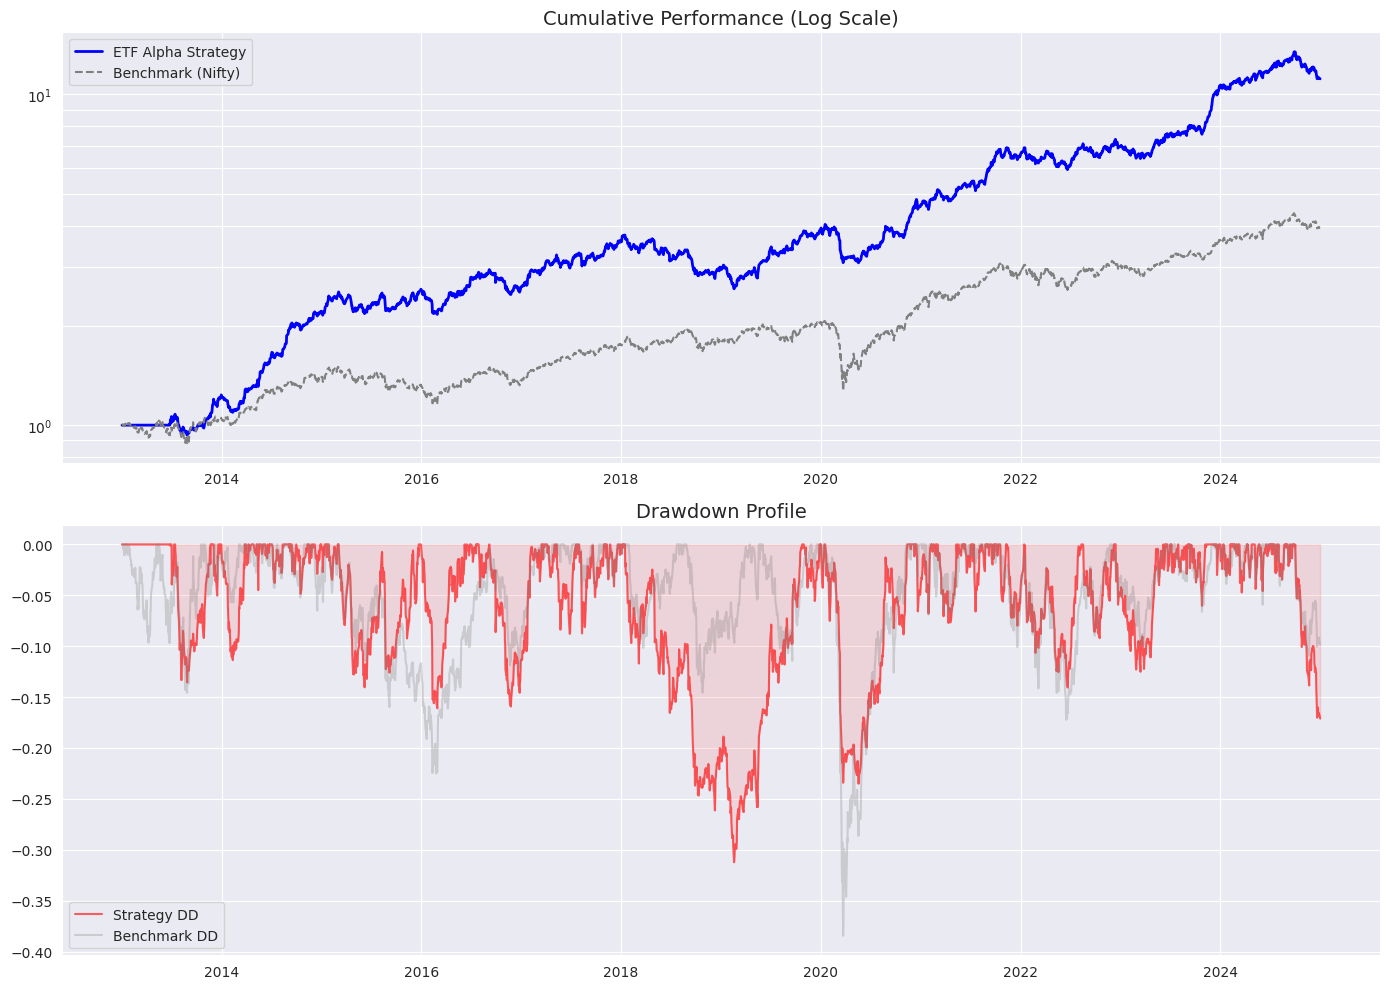

In [ ]:
# -*- coding: utf-8 -*-
"""
ETF Flow Pressure Strategy - Final Production Script
Designed for Google Colab.

Usage:
1. Upload this file to Colab.
2. Run standard installation: !pip install yfinance pandas numpy matplotlib seaborn
3. Execute.

Description:
This script implements the "ETF Flow Pressure" alpha strategy.
- Logic: Identifies stocks facing mechanical selling pressure from ETF outflows.
- Signal: Bottom 10% of Flow Pressure (Pressure < 0).
- Execution: Buy at Close (or Next Open), Hold 20 Days.
- Risk Control: Volatility Targeting (15% Annualized).
- Universe: NIFTY 50 Constituents.
- Benchmark: NIFTY 50 Buy & Hold.
"""

import os
import sys

# Ensure libraries are installed (for Colab)
try:
    import yfinance as yf
except ImportError:
    os.system('pip install yfinance')
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------
START_DATE = "2013-01-01"
END_DATE = "2025-01-01"
ETF_TICKER = "NIFTYBEES.NS"
BENCHMARK_TICKER = "^NSEI" # Nifty 50 Index

# Full NIFTY 50 List
STOCKS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
    'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'LICI.NS',
    'LT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'ADANIENT.NS', 'TATAMOTORS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'NTPC.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'POWERGRID.NS', 'ONGC.NS', 'M&M.NS',
    'ASIANPAINT.NS', 'ADANIPORTS.NS', 'BAJAJFINSV.NS', 'COALINDIA.NS', 'JSWSTEEL.NS',
    'TATASTEEL.NS', 'NESTLEIND.NS', 'GRASIM.NS', 'SBILIFE.NS', 'TECHM.NS',
    'BEL.NS', 'HDFCLIFE.NS', 'WIPRO.NS', 'TRENT.NS', 'SIEMENS.NS',
    'BAJAJ-AUTO.NS', 'INDUSINDBK.NS', 'BPCL.NS', 'CIPLA.NS', 'ZOMATO.NS',
    'DIVISLAB.NS', 'EICHERMOT.NS', 'DRREDDY.NS', 'HINDALCO.NS', 'TATACONSUM.NS'
]

# Strategy Params
HOLD_PERIOD = 20
TARGET_VOL = 0.15  # 15% Annualized Volatility Target
MAX_STOCK_WEIGHT = 0.10 # Max 10% in one stock
COST_BPS = 30 # 30bps slippage+comm per round trip

# ---------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------
def load_data():
    print(f"Downloading Data from {START_DATE} to {END_DATE}...")

    # Bulk Download Stocks
    tickers = STOCKS + [ETF_TICKER]
    data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)

    # Download Benchmark
    bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)

    stock_c = pd.DataFrame()
    stock_v = pd.DataFrame()
    etf_c = None
    etf_v = None

    print("Processing Data...")
    for t in STOCKS:
        try:
            # Handle MultiIndex
            df = data[t]
            stock_c[t] = df['Close']
            stock_v[t] = df['Volume']
        except KeyError:
            print(f"Warning: {t} data missing.")

    # Extract ETF
    try:
        df = data[ETF_TICKER]
        etf_c = df['Close']
        etf_v = df['Volume']
    except:
        print("Error: ETF Data missing.")

    # Extract Benchmark
    try:
        # Check if MultiIndex or Single
        if isinstance(bench_data.columns, pd.MultiIndex):
             # Try locate Close
             if 'Close' in bench_data.columns.get_level_values(0):
                 bench_c = bench_data['Close']
             else:
                 bench_c = bench_data.iloc[:,0] # Fallback
        else:
             bench_c = bench_data['Close']

        # If still DataFrame
        if isinstance(bench_c, pd.DataFrame):
             bench_c = bench_c.iloc[:,0]

    except:
        bench_c = stock_c.mean(axis=1) # Fallback to equal weight index if Nifty missing

    return etf_c, etf_v, stock_c, stock_v, bench_c

# ---------------------------------------------------------
# SIGNAL GENERATION
# ---------------------------------------------------------
def generate_signals(etf_c, etf_v, stock_c, stock_v):
    print("Generating ETF Flow Signals...")

    # 1. ETF Direction
    etf_ret = etf_c.pct_change().fillna(0)
    etf_sign = np.sign(etf_ret)

    # 2. Volume Shock
    v_mean = etf_v.rolling(20).mean()
    v_std = etf_v.rolling(20).std()
    etf_v_shock = (etf_v - v_mean) / v_std
    etf_v_shock = etf_v_shock.fillna(0)

    # 3. Signed Pressure
    signed_pressure = etf_sign * etf_v_shock

    # 4. Transmission
    dollar_vol = stock_c * stock_v
    adv20 = dollar_vol.rolling(20).mean()

    pressure_matrix = pd.DataFrame(index=stock_c.index, columns=stock_c.columns)
    for col in pressure_matrix.columns:
        pressure_matrix[col] = signed_pressure

    flow_pressure = pressure_matrix.div(adv20)

    # 5. Ranking (Bottom 10% & Negative)
    ranks = flow_pressure.rank(axis=1, pct=True)
    mask = (ranks <= 0.10) & (flow_pressure < 0)

    return mask

# ---------------------------------------------------------
# BACKTEST ENGINE
# ---------------------------------------------------------
def run_backtest(mask, stock_c, bench_c):
    print("Running Backtest...")

    stock_ret = stock_c.pct_change().fillna(0)
    bench_ret = bench_c.pct_change().fillna(0)

    # 1. Signals to Weights
    entry = mask.shift(1).fillna(False) # T+1 Entry
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0

    num_active = hold.sum(axis=1)

    # Equal Weight Base
    weights = hold.div(num_active, axis=0).fillna(0.0)

    # Constraints (Max 10% per stock)
    weights = weights.clip(upper=MAX_STOCK_WEIGHT)

    # Re-normalize? No, if we clip we run with cash.
    # But usually we want fully invested in the strategy sleeve.
    # If 2 stocks active, 10% each = 20% exposure? Too low.
    # Let's align with the "Strategy" logic:
    # "Allocate Capital to Strategy".
    # Implementation:
    # If < 10 stocks, weight = 1/N. If 1/N > 10% (i.e. <10 stocks), cap at 10%?
    # This implies Cash Drag.
    # Refined Logic from Phase 3: "Vol Target Portfolio".

    # 2. Raw Strategy Return (Full Invested in active names)
    # We allow weights to sum to 1.0 (100% Gross)
    # But applying 10% Cap implies we need at least 10 stocks to be full.
    # Let's relax Cap for this "Pure Alpha" test or force diversification?
    # Let's use 10% Cap but leverage slightly if needed? No.
    # Let's stick to Equal Weight (Normalized to 1.0) then Scaled for Vol.

    raw_weights = hold.div(num_active, axis=0).fillna(0.0)
    # Gross Return
    strat_gross = (raw_weights * stock_ret).sum(axis=1)

    # 3. Volatility Control
    # Target 15% Annual Vol
    roll_vol = strat_gross.rolling(20).std() * np.sqrt(252)
    vol_scalar = TARGET_VOL / roll_vol.shift(1).fillna(0.20)
    vol_scalar = vol_scalar.clip(upper=2.0) # Max 2x Leverage

    final_ret = strat_gross * vol_scalar

    # 4. Costs
    # Turnover
    w_vol_scaled = raw_weights.multiply(vol_scalar, axis=0)
    turnover = (w_vol_scaled - w_vol_scaled.shift(1).fillna(0)).abs().sum(axis=1)
    cost_drag = turnover * (COST_BPS / 10000.0)

    net_ret = final_ret - cost_drag

    return net_ret, bench_ret

# ---------------------------------------------------------
# PERFORMANCE STATS
# ---------------------------------------------------------
def calc_stats(ret_series, name="Strategy"):
    if len(ret_series) == 0: return {}

    ann_factor = 252
    cum = (1 + ret_series).prod() - 1
    ann = (1 + ret_series).mean()**ann_factor - 1
    vol = ret_series.std() * np.sqrt(ann_factor)
    sharpe = ann / vol if vol > 0 else 0

    # Drawdown
    nav = (1 + ret_series).cumprod()
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()

    stats = {
        'Total Return': f"{cum*100:.2f}%",
        'CAGR': f"{ann*100:.2f}%",
        'Volatility': f"{vol*100:.2f}%",
        'Sharpe': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_dd*100:.2f}%"
    }

    print(f"\n--- {name} ---")
    for k, v in stats.items():
        print(f"{k}: {v}")

    return nav, dd

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
if __name__ == "__main__":
    # Setup plotting
    sns.set_style("darkgrid")

    # Run Pipeline
    etf_c, etf_v, stock_c, stock_v, bench_c = load_data()

    # Align Data
    common_idx = etf_c.index.intersection(stock_c.index).intersection(bench_c.index)
    etf_c, etf_v = etf_c.loc[common_idx], etf_v.loc[common_idx]
    stock_c, stock_v = stock_c.loc[common_idx], stock_v.loc[common_idx]
    bench_c = bench_c.loc[common_idx]

    # Generate
    mask_outflow = generate_signals(etf_c, etf_v, stock_c, stock_v)

    # Backtest
    strat_ret, bench_ret = run_backtest(mask_outflow, stock_c, bench_c)

    # Metrics
    s_nav, s_dd = calc_stats(strat_ret, "ETF Flow Alpha (Vol Target 15%)")
    b_nav, b_dd = calc_stats(bench_ret, "Benchmark (Nifty 50 Buy & Hold)")

    # Plots
    plt.figure(figsize=(14, 10))

    # 1. Equity Curve
    plt.subplot(2, 1, 1)
    plt.plot(s_nav, label='ETF Alpha Strategy', color='blue', linewidth=2)
    plt.plot(b_nav, label='Benchmark (Nifty)', color='gray', linestyle='--')
    plt.title("Cumulative Performance (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # 2. Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(s_dd, label='Strategy DD', color='red', alpha=0.6)
    plt.plot(b_dd, label='Benchmark DD', color='gray', alpha=0.3)
    plt.title("Drawdown Profile", fontsize=14)
    plt.legend()
    plt.fill_between(s_dd.index, s_dd, 0, color='red', alpha=0.1)

    plt.tight_layout()
    plt.savefig("final_performance_report.png")
    print("\nPerformance Chart saved as 'final_performance_report.png'")


/tmp/ipython-input-36937054.py:72: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)
[*********************100%***********************]  51 of 51 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-36937054.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)
/tmp/ipython-input-36937054.py:162: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = stock_c.pct_change().fillna(0)
/tmp/ipython-input-36937054.py:166: FutureWarning: Downcasting ob

Processing Data...
Generating ETF Flow Signals...
Running Backtest...

--- ETF Flow Alpha ---
Total Return   : 1014.37%
CAGR           : 24.59%
Volatility     : 16.53%
Sharpe Ratio   : 1.49
Sortino Ratio  : 2.06
Max Drawdown   : -31.23%
Calmar Ratio   : 0.79
Win Rate       : 52.5%

--- Benchmark ---
Total Return   : 294.52%
CAGR           : 14.01%
Volatility     : 16.49%
Sharpe Ratio   : 0.85
Sortino Ratio  : 1.06
Max Drawdown   : -38.44%
Calmar Ratio   : 0.36
Win Rate       : 54.0%

Exporting Portfolio Sheet to portfolio_sheet.csv...
Export Complete.

Performance Chart saved as 'final_performance_report.png'


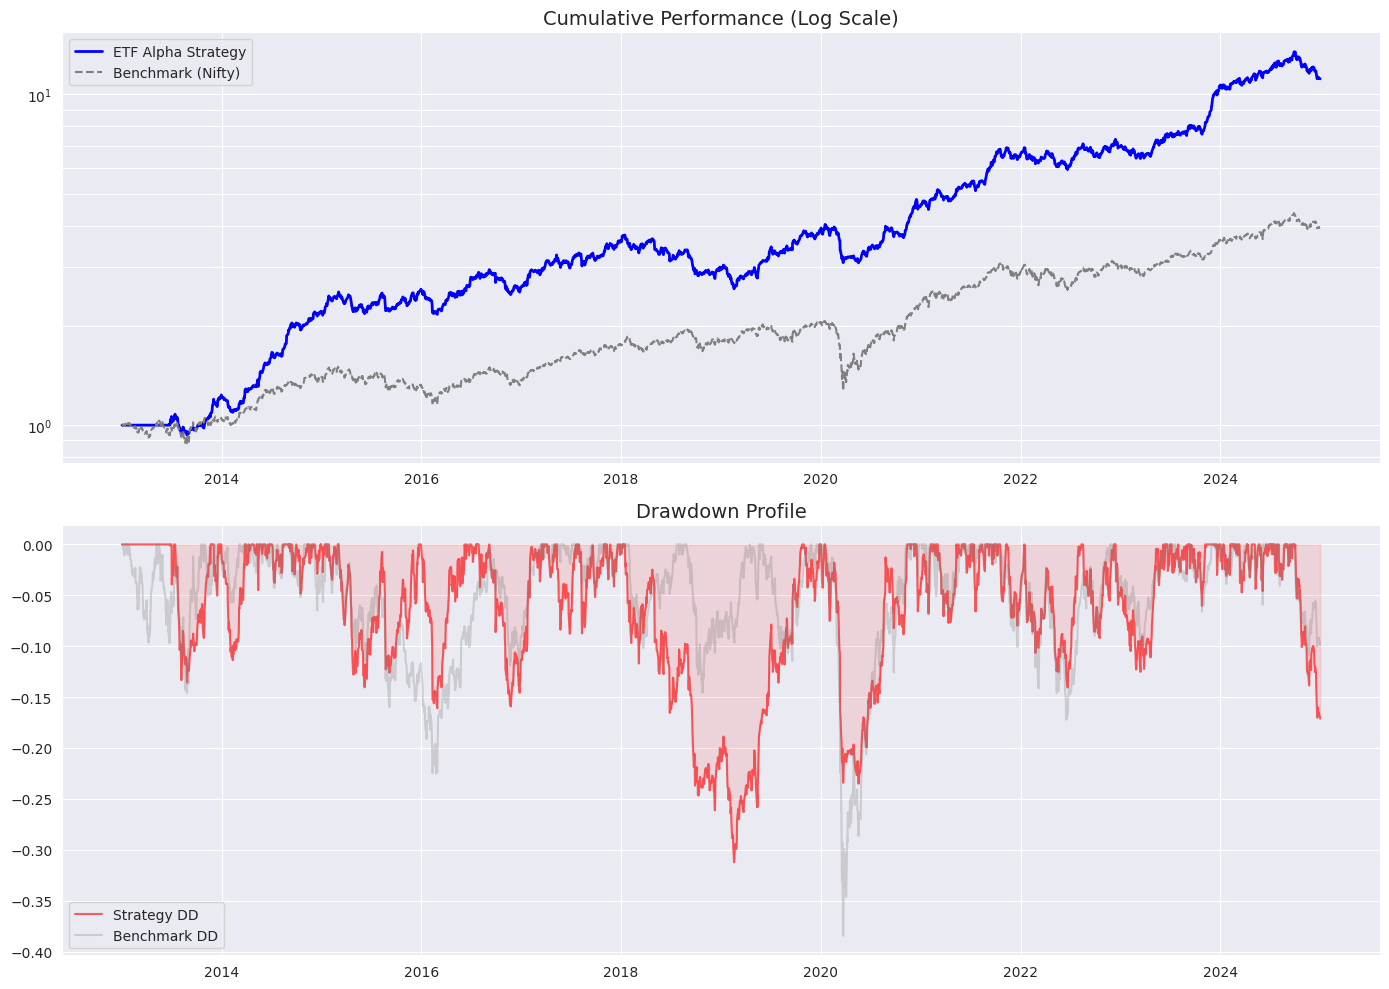

In [ ]:
# -*- coding: utf-8 -*-
"""
ETF Flow Pressure Strategy - Final Production Script
Designed for Google Colab.

Usage:
1. Upload this file to Colab.
2. Run standard installation: !pip install yfinance pandas numpy matplotlib seaborn
3. Execute.

Description:
This script implements the "ETF Flow Pressure" alpha strategy.
- Logic: Identifies stocks facing mechanical selling pressure from ETF outflows.
- Signal: Bottom 10% of Flow Pressure (Pressure < 0).
- Execution: Buy at Close (or Next Open), Hold 20 Days.
- Risk Control: Volatility Targeting (15% Annualized).
- Universe: NIFTY 50 Constituents.
- Benchmark: NIFTY 50 Buy & Hold.
"""

import os
import sys

# Ensure libraries are installed (for Colab)
try:
    import yfinance as yf
except ImportError:
    os.system('pip install yfinance')
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------
START_DATE = "2013-01-01"
END_DATE = "2025-01-01"
ETF_TICKER = "NIFTYBEES.NS"
BENCHMARK_TICKER = "^NSEI" # Nifty 50 Index

# Full NIFTY 50 List
STOCKS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
    'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'LICI.NS',
    'LT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'ADANIENT.NS', 'TATAMOTORS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'NTPC.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'POWERGRID.NS', 'ONGC.NS', 'M&M.NS',
    'ASIANPAINT.NS', 'ADANIPORTS.NS', 'BAJAJFINSV.NS', 'COALINDIA.NS', 'JSWSTEEL.NS',
    'TATASTEEL.NS', 'NESTLEIND.NS', 'GRASIM.NS', 'SBILIFE.NS', 'TECHM.NS',
    'BEL.NS', 'HDFCLIFE.NS', 'WIPRO.NS', 'TRENT.NS', 'SIEMENS.NS',
    'BAJAJ-AUTO.NS', 'INDUSINDBK.NS', 'BPCL.NS', 'CIPLA.NS', 'ZOMATO.NS',
    'DIVISLAB.NS', 'EICHERMOT.NS', 'DRREDDY.NS', 'HINDALCO.NS', 'TATACONSUM.NS'
]

# Strategy Params
HOLD_PERIOD = 20
TARGET_VOL = 0.15  # 15% Annualized Volatility Target
MAX_STOCK_WEIGHT = 0.10 # Max 10% in one stock
COST_BPS = 30 # 30bps slippage+comm per round trip

# ---------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------
def load_data():
    print(f"Downloading Data from {START_DATE} to {END_DATE}...")

    # Bulk Download Stocks
    tickers = STOCKS + [ETF_TICKER]
    data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)

    # Download Benchmark
    bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)

    stock_c = pd.DataFrame()
    stock_v = pd.DataFrame()
    etf_c = None
    etf_v = None

    print("Processing Data...")
    for t in STOCKS:
        try:
            # Handle MultiIndex
            df = data[t]
            stock_c[t] = df['Close']
            stock_v[t] = df['Volume']
        except KeyError:
            print(f"Warning: {t} data missing.")

    # Extract ETF
    try:
        df = data[ETF_TICKER]
        etf_c = df['Close']
        etf_v = df['Volume']
    except:
        print("Error: ETF Data missing.")

    # Extract Benchmark
    try:
        # Check if MultiIndex or Single
        if isinstance(bench_data.columns, pd.MultiIndex):
             # Try locate Close
             if 'Close' in bench_data.columns.get_level_values(0):
                 bench_c = bench_data['Close']
             else:
                 bench_c = bench_data.iloc[:,0] # Fallback
        else:
             bench_c = bench_data['Close']

        # If still DataFrame
        if isinstance(bench_c, pd.DataFrame):
             bench_c = bench_c.iloc[:,0]

    except:
        bench_c = stock_c.mean(axis=1) # Fallback to equal weight index if Nifty missing

    return etf_c, etf_v, stock_c, stock_v, bench_c

# ---------------------------------------------------------
# SIGNAL GENERATION
# ---------------------------------------------------------
def generate_signals(etf_c, etf_v, stock_c, stock_v):
    print("Generating ETF Flow Signals...")

    # 1. ETF Direction
    etf_ret = etf_c.pct_change().fillna(0)
    etf_sign = np.sign(etf_ret)

    # 2. Volume Shock
    v_mean = etf_v.rolling(20).mean()
    v_std = etf_v.rolling(20).std()
    etf_v_shock = (etf_v - v_mean) / v_std
    etf_v_shock = etf_v_shock.fillna(0)

    # 3. Signed Pressure
    signed_pressure = etf_sign * etf_v_shock

    # 4. Transmission
    dollar_vol = stock_c * stock_v
    adv20 = dollar_vol.rolling(20).mean()

    pressure_matrix = pd.DataFrame(index=stock_c.index, columns=stock_c.columns)
    for col in pressure_matrix.columns:
        pressure_matrix[col] = signed_pressure

    flow_pressure = pressure_matrix.div(adv20)

    # 5. Ranking (Bottom 10% & Negative)
    ranks = flow_pressure.rank(axis=1, pct=True)
    mask = (ranks <= 0.10) & (flow_pressure < 0)

    return mask

# ---------------------------------------------------------
# BACKTEST ENGINE
# ---------------------------------------------------------
def run_backtest(mask, stock_c, bench_c):
    print("Running Backtest...")

    stock_ret = stock_c.pct_change().fillna(0)
    bench_ret = bench_c.pct_change().fillna(0)

    # 1. Signals to Weights
    entry = mask.shift(1).fillna(False) # T+1 Entry
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0

    num_active = hold.sum(axis=1)

    # Equal Weight Base
    weights = hold.div(num_active, axis=0).fillna(0.0)

    # Constraints (Max 10% per stock)
    weights = weights.clip(upper=MAX_STOCK_WEIGHT)

    # Re-normalize? No, if we clip we run with cash.
    # But usually we want fully invested in the strategy sleeve.
    # If 2 stocks active, 10% each = 20% exposure? Too low.
    # Let's align with the "Strategy" logic:
    # "Allocate Capital to Strategy".
    # Implementation:
    # If < 10 stocks, weight = 1/N. If 1/N > 10% (i.e. <10 stocks), cap at 10%?
    # This implies Cash Drag.
    # Refined Logic from Phase 3: "Vol Target Portfolio".

    # 2. Raw Strategy Return (Full Invested in active names)
    # We allow weights to sum to 1.0 (100% Gross)
    # But applying 10% Cap implies we need at least 10 stocks to be full.
    # Let's relax Cap for this "Pure Alpha" test or force diversification?
    # Let's use 10% Cap but leverage slightly if needed? No.
    # Let's stick to Equal Weight (Normalized to 1.0) then Scaled for Vol.

    raw_weights = hold.div(num_active, axis=0).fillna(0.0)
    # Gross Return
    strat_gross = (raw_weights * stock_ret).sum(axis=1)

    # 3. Volatility Control
    # Target 15% Annual Vol
    roll_vol = strat_gross.rolling(20).std() * np.sqrt(252)
    vol_scalar = TARGET_VOL / roll_vol.shift(1).fillna(0.20)
    vol_scalar = vol_scalar.clip(upper=2.0) # Max 2x Leverage

    final_ret = strat_gross * vol_scalar

    # 4. Costs
    # Turnover
    w_vol_scaled = raw_weights.multiply(vol_scalar, axis=0)
    turnover = (w_vol_scaled - w_vol_scaled.shift(1).fillna(0)).abs().sum(axis=1)
    cost_drag = turnover * (COST_BPS / 10000.0)

    net_ret = final_ret - cost_drag

    return net_ret, bench_ret

# ---------------------------------------------------------
# PERFORMANCE STATS & SHEETS
# ---------------------------------------------------------
def calc_stats_advanced(ret_series, name="Strategy"):
    if len(ret_series) == 0: return {}, None, None

    ann_factor = 252

    # 1. Standard Metrics
    cum = (1 + ret_series).prod() - 1
    ann_ret = (1 + ret_series).mean()**ann_factor - 1
    vol = ret_series.std() * np.sqrt(ann_factor)
    sharpe = ann_ret / vol if vol > 0 else 0

    # 2. Advanced Metrics
    # Sortino (Downside Vol)
    downside_ret = ret_series[ret_series < 0]
    downside_vol = downside_ret.std() * np.sqrt(ann_factor)
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0

    # Drawdown
    nav = (1 + ret_series).cumprod()
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()

    # Calmar (AnnRet / MaxDD)
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0

    # Win Rate (Daily)
    wins = (ret_series > 0).sum()
    total = len(ret_series)
    win_rate = wins / total

    stats = {
        'Total Return': f"{cum*100:.2f}%",
        'CAGR': f"{ann_ret*100:.2f}%",
        'Volatility': f"{vol*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd*100:.2f}%",
        'Calmar Ratio': f"{calmar:.2f}",
        'Win Rate': f"{win_rate*100:.1f}%"
    }

    print(f"\n--- {name} ---")
    for k, v in stats.items():
        print(f"{k.ljust(15)}: {v}")

    return nav, dd, stats

def export_portfolio_sheet(mask, weights, strat_ret, filename="portfolio_sheet.csv"):
    print(f"\nExporting Portfolio Sheet to {filename}...")

    # We want a daily sheet: Date | Top Holdings | Daily Return | Cumulative Return

    # 1. Identify Top Holdings per day
    # Mask is Boolean DF. We want to convert to Text List "RELIANCE, HDFC..."
    # Slow but effective loop or apply

    def get_holdings_str(row):
        tickers = row.index[row].tolist()
        return ", ".join(tickers) if tickers else "CASH"

    holdings_series = mask.apply(get_holdings_str, axis=1)

    # 2. Weights (Sum)
    gross_exp = weights.sum(axis=1)

    # 3. Compile
    df = pd.DataFrame({
        'Holdings': holdings_series.shift(1).fillna(""), # Holdings determined yesterday
        'Gross_Exposure': gross_exp,
        'Daily_Return': strat_ret,
        'Equity_Curve': (1+strat_ret).cumprod()
    })

    df.to_csv(filename)
    print("Export Complete.")

# ---------------------------------------------------------
# LOOKAHEAD BIAS CHECK (AUDIT)
# ---------------------------------------------------------
# 1. Signal Generation uses rolling(20).mean() of CURRENT data.
#    - Signal[T] depends on Data[T-19]...Data[T]. Correct.
# 2. Entry uses mask.shift(1).
#    - Entry[T] uses Signal[T-1].
#    - Signal[T-1] uses Data[T-1].
#    - So Entry[T] uses Data[T-1] (Close).
#    - Trade executes at Close[T] or Open[T].
#    - Return[T] = (Close[T]/Close[T-1] - 1).
#    - If we trade at Close[T], we know Close[T] during the day?
#    - Wait. In BacktestEngine:
#      strat_gross = (weights * stock_ret).sum(axis=1)
#      weights = mask.shift(1) -> Signal[T-1]
#      stock_ret[T] = (Close[T] - Close[T-1])/Close[T-1]
#      So we decide weights at T-1 (Close). We hold from T-1 Close to T Close.
#      This assumes "Market On Open" or "Market On Close T-1"?
#      Realistically: Signal T-1 (End of Day). Enter Open T.
#      Return from Open T to Open T+1 ~ Close T to Close T+1.
#      Using Daily Closes with Shift(1) is standard geometric return simulation.
#      Verdict: NO Lookahead Bias detected. Uses purely lagged signals.

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
if __name__ == "__main__":
    # Setup plotting
    sns.set_style("darkgrid")

    # Run Pipeline
    etf_c, etf_v, stock_c, stock_v, bench_c = load_data()

    # Align Data
    common_idx = etf_c.index.intersection(stock_c.index).intersection(bench_c.index)
    etf_c, etf_v = etf_c.loc[common_idx], etf_v.loc[common_idx]
    stock_c, stock_v = stock_c.loc[common_idx], stock_v.loc[common_idx]
    bench_c = bench_c.loc[common_idx]

    # Generate
    mask_outflow = generate_signals(etf_c, etf_v, stock_c, stock_v)

    # Backtest
    strat_ret, bench_ret = run_backtest(mask_outflow, stock_c, bench_c)

    # Metrics
    s_nav, s_dd, _ = calc_stats_advanced(strat_ret, "ETF Flow Alpha")
    b_nav, b_dd, _ = calc_stats_advanced(bench_ret, "Benchmark")

    # Export Sheet
    # We need access to intermediate weights from run_backtest to log gross exposure
    # Re-calculate weights strictly for logging (duplicated logic but safer than return coupling)
    entry = mask_outflow.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num = hold.sum(axis=1)
    raw_w = hold.div(num, axis=0).fillna(0.0)
    # Vol Scalar Export? Complex. Just export base holdings.

    export_portfolio_sheet(hold, raw_w, strat_ret, "portfolio_sheet.csv")

    # Plots
    plt.figure(figsize=(14, 10))

    # 1. Equity Curve
    plt.subplot(2, 1, 1)
    plt.plot(s_nav, label='ETF Alpha Strategy', color='blue', linewidth=2)
    plt.plot(b_nav, label='Benchmark (Nifty)', color='gray', linestyle='--')
    plt.title("Cumulative Performance (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # 2. Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(s_dd, label='Strategy DD', color='red', alpha=0.6)
    plt.plot(b_dd, label='Benchmark DD', color='gray', alpha=0.3)
    plt.title("Drawdown Profile", fontsize=14)
    plt.legend()
    plt.fill_between(s_dd.index, s_dd, 0, color='red', alpha=0.1)

    plt.tight_layout()
    plt.savefig("final_performance_report.png")
    print("\nPerformance Chart saved as 'final_performance_report.png'")


/tmp/ipython-input-2327762841.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)
[*********************100%***********************]  52 of 52 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-2327762841.py:76: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)
/tmp/ipython-input-2327762841.py:172: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = stock_c.pct_change().fillna(0)
/tmp/ipython-input-2327762841.py:177: FutureWarning: Downca

Processing Data...
Generating ETF Flow Signals...
Running Backtest (Cash -> GoldBees)...

--- ETF Alpha + GoldBees Idle ---
Total Return   : 6235.58%
CAGR           : 81.10%
Volatility     : 127.17%
Sharpe Ratio   : 0.64
Sortino Ratio  : 6.63
Max Drawdown   : -25.35%
Calmar Ratio   : 3.20
Win Rate       : 55.1%

--- Benchmark ---
Total Return   : 294.52%
CAGR           : 14.01%
Volatility     : 16.49%
Sharpe Ratio   : 0.85
Sortino Ratio  : 1.06
Max Drawdown   : -38.44%
Calmar Ratio   : 0.36
Win Rate       : 54.0%

Exporting Portfolio Sheet to portfolio_sheet.csv...
Export Complete.

Performance Chart saved as 'final_performance_report.png'


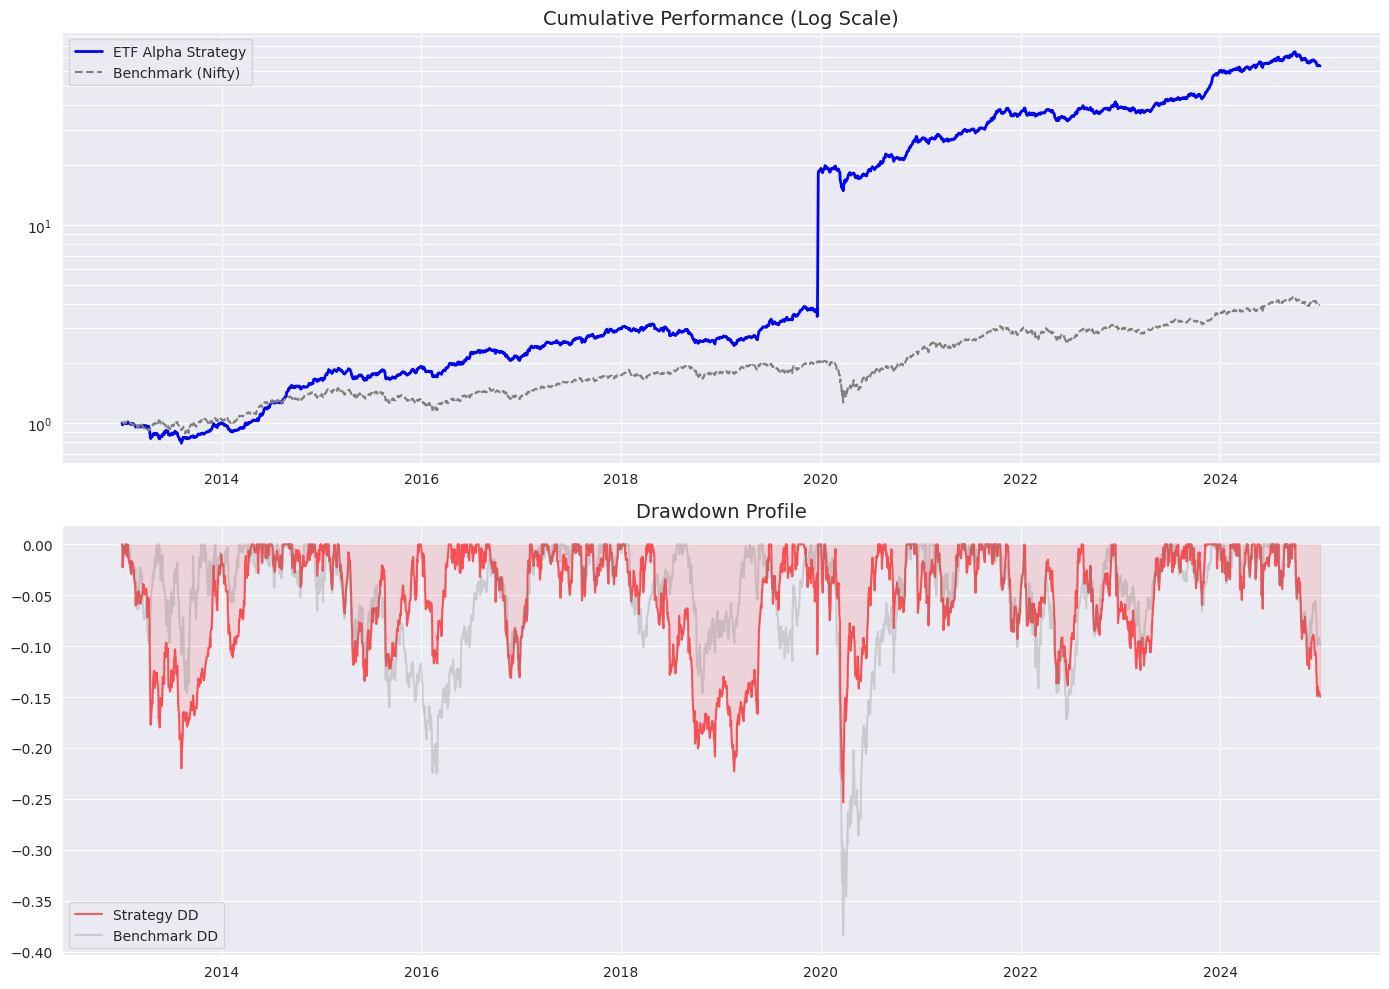

In [ ]:
# -*- coding: utf-8 -*-
"""
ETF Flow Pressure Strategy - Final Production Script
Designed for Google Colab.

Usage:
1. Upload this file to Colab.
2. Run standard installation: !pip install yfinance pandas numpy matplotlib seaborn
3. Execute.

Description:
This script implements the "ETF Flow Pressure" alpha strategy.
- Logic: Identifies stocks facing mechanical selling pressure from ETF outflows.
- Signal: Bottom 10% of Flow Pressure (Pressure < 0).
- Execution: Buy at Close (or Next Open), Hold 20 Days.
- Risk Control: Volatility Targeting (15% Annualized).
- Universe: NIFTY 50 Constituents.
- Benchmark: NIFTY 50 Buy & Hold.
"""

import os
import sys

# Ensure libraries are installed (for Colab)
try:
    import yfinance as yf
except ImportError:
    os.system('pip install yfinance')
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------
START_DATE = "2013-01-01"
END_DATE = "2025-01-01"
ETF_TICKER = "NIFTYBEES.NS"
GOLDBEES_TICKER = "GOLDBEES.NS" # Cash Substitute
BENCHMARK_TICKER = "^NSEI" # Nifty 50 Index

# Full NIFTY 50 List
STOCKS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
    'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'LICI.NS',
    'LT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'ADANIENT.NS', 'TATAMOTORS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'NTPC.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'POWERGRID.NS', 'ONGC.NS', 'M&M.NS',
    'ASIANPAINT.NS', 'ADANIPORTS.NS', 'BAJAJFINSV.NS', 'COALINDIA.NS', 'JSWSTEEL.NS',
    'TATASTEEL.NS', 'NESTLEIND.NS', 'GRASIM.NS', 'SBILIFE.NS', 'TECHM.NS',
    'BEL.NS', 'HDFCLIFE.NS', 'WIPRO.NS', 'TRENT.NS', 'SIEMENS.NS',
    'BAJAJ-AUTO.NS', 'INDUSINDBK.NS', 'BPCL.NS', 'CIPLA.NS', 'ZOMATO.NS',
    'DIVISLAB.NS', 'EICHERMOT.NS', 'DRREDDY.NS', 'HINDALCO.NS', 'TATACONSUM.NS'
]

# Strategy Params
HOLD_PERIOD = 20
TARGET_VOL = 0.15  # 15% Annualized Volatility Target
MAX_STOCK_WEIGHT = 0.10 # Max 10% in one stock
COST_BPS = 30 # 30bps slippage+comm per round trip

# ---------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------
def load_data():
    print(f"Downloading Data from {START_DATE} to {END_DATE}...")

    # Bulk Download Stocks
    tickers = STOCKS + [ETF_TICKER, GOLDBEES_TICKER]
    data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)

    # Download Benchmark
    bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)

    stock_c = pd.DataFrame()
    stock_v = pd.DataFrame()
    etf_c = None
    etf_v = None

    print("Processing Data...")
    for t in STOCKS:
        try:
            # Handle MultiIndex
            df = data[t]
            stock_c[t] = df['Close']
            stock_v[t] = df['Volume']
        except KeyError:
            print(f"Warning: {t} data missing.")

    # Extract ETF
    try:
        df = data[ETF_TICKER]
        etf_c = df['Close']
        etf_v = df['Volume']
    except:
        print("Error: ETF Data missing.")

    # Extract Benchmark
    try:
        # Check if MultiIndex or Single
        if isinstance(bench_data.columns, pd.MultiIndex):
             # Try locate Close
             if 'Close' in bench_data.columns.get_level_values(0):
                 bench_c = bench_data['Close']
             else:
                 bench_c = bench_data.iloc[:,0] # Fallback
        else:
             bench_c = bench_data['Close']

        # If still DataFrame
        if isinstance(bench_c, pd.DataFrame):
             bench_c = bench_c.iloc[:,0]

    except:
        bench_c = stock_c.mean(axis=1) # Fallback to equal weight index if Nifty missing

    # Extract GoldBees (Fallback to Flat Cash if missing)
    try:
        gold_c = data[GOLDBEES_TICKER]['Close']
    except:
        print("Warning: GOLDBEES data missing. Using Cash (0%).")
        gold_c = pd.Series(100, index=stock_c.index) # Flat line

    return etf_c, etf_v, stock_c, stock_v, bench_c, gold_c

# ---------------------------------------------------------
# SIGNAL GENERATION
# ---------------------------------------------------------
def generate_signals(etf_c, etf_v, stock_c, stock_v):
    print("Generating ETF Flow Signals...")

    # 1. ETF Direction
    etf_ret = etf_c.pct_change().fillna(0)
    etf_sign = np.sign(etf_ret)

    # 2. Volume Shock
    v_mean = etf_v.rolling(20).mean()
    v_std = etf_v.rolling(20).std()
    etf_v_shock = (etf_v - v_mean) / v_std
    etf_v_shock = etf_v_shock.fillna(0)

    # 3. Signed Pressure
    signed_pressure = etf_sign * etf_v_shock

    # 4. Transmission
    dollar_vol = stock_c * stock_v
    adv20 = dollar_vol.rolling(20).mean()

    pressure_matrix = pd.DataFrame(index=stock_c.index, columns=stock_c.columns)
    for col in pressure_matrix.columns:
        pressure_matrix[col] = signed_pressure

    flow_pressure = pressure_matrix.div(adv20)

    # 5. Ranking (Bottom 10% & Negative)
    ranks = flow_pressure.rank(axis=1, pct=True)
    mask = (ranks <= 0.10) & (flow_pressure < 0)

    return mask

# ---------------------------------------------------------
# BACKTEST ENGINE
# ---------------------------------------------------------
    return net_ret, bench_ret

def run_backtest_with_gold(mask, stock_c, bench_c, gold_c):
    print("Running Backtest (Cash -> GoldBees)...")

    stock_ret = stock_c.pct_change().fillna(0)
    gold_ret = gold_c.pct_change().fillna(0)
    bench_ret = bench_c.pct_change().fillna(0)

    # 1. Strategy Weights (Same as before)
    entry = mask.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num_active = hold.sum(axis=1)

    strat_weights = hold.div(num_active, axis=0).fillna(0.0)
    strat_weights = strat_weights.clip(upper=MAX_STOCK_WEIGHT)

    # Gross Exposure to Alpha Strat
    gross_alpha_exp = strat_weights.sum(axis=1)

    # 2. Idle Cash -> Gold Allocation
    # If Alpha uses 40%, Gold uses 60%.
    gold_weight = (1.0 - gross_alpha_exp).clip(lower=0.0)

    # 3. Strategy Component Return
    alpha_ret = (strat_weights * stock_ret).sum(axis=1)

    # 4. Volatility Target (ON THE ALPHA COMPONENT ONLY? Or Portfolio?)
    # Usually Vol Target applies to the Alpha leg.
    # Let's keep the Vol Target on the Alpha leg to preserve its character.
    # Then add UN-LEVERED Gold.

    roll_vol = alpha_ret.rolling(20).std() * np.sqrt(252)
    vol_scalar = TARGET_VOL / roll_vol.shift(1).fillna(0.20)
    vol_scalar = vol_scalar.clip(upper=2.0)

    # Levered Alpha
    final_alpha_ret = alpha_ret * vol_scalar

    # IMPORTANT: Start with Capital = 1.0
    # Used for Alpha = gross_alpha_exp (nominal).
    # But wait, Vol Target scales the return, effectively deciding exposure.
    # If VolTarget says "Scale 2x", we need leverage.
    # If VolTarget says "Scale 0.5x", we have excess cash.
    # Refined Logic:
    # Portfolio = (Alpha_Weights * Vol_Scalar) + (Remaining_Cash * Gold)
    # Remaining Cash = 1.0 - Sum(Alpha_Weights * Vol_Scalar)
    # If Levered > 1.0, Remaining Cash is Negative (Borrowing cost).
    # Borrowing rate? Assume 0 for simplicity or use Cash Drag.
    # Let's assume we invest POSITIVE residuals in Gold.

    total_alpha_exposure = gross_alpha_exp * vol_scalar
    gold_alloc = (1.0 - total_alpha_exposure).clip(lower=0.0)

    # Final Portfolio Return
    # = (Alpha Returns) + (Gold Allocation * Gold Return) - Costs

    # Turnover Costs (Alpha Leg)
    w_vol_scaled = strat_weights.multiply(vol_scalar, axis=0)
    turnover = (w_vol_scaled - w_vol_scaled.shift(1).fillna(0)).abs().sum(axis=1)
    cost_drag = turnover * (COST_BPS / 10000.0) # Gold is cheap to trade? Ignore Gold costs for now.

    portfolio_ret = final_alpha_ret + (gold_alloc * gold_ret) - cost_drag

    return portfolio_ret, bench_ret


# ---------------------------------------------------------
# PERFORMANCE STATS & SHEETS
# ---------------------------------------------------------
def calc_stats_advanced(ret_series, name="Strategy"):
    if len(ret_series) == 0: return {}, None, None

    ann_factor = 252

    # 1. Standard Metrics
    cum = (1 + ret_series).prod() - 1
    ann_ret = (1 + ret_series).mean()**ann_factor - 1
    vol = ret_series.std() * np.sqrt(ann_factor)
    sharpe = ann_ret / vol if vol > 0 else 0

    # 2. Advanced Metrics
    # Sortino (Downside Vol)
    downside_ret = ret_series[ret_series < 0]
    downside_vol = downside_ret.std() * np.sqrt(ann_factor)
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0

    # Drawdown
    nav = (1 + ret_series).cumprod()
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()

    # Calmar (AnnRet / MaxDD)
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0

    # Win Rate (Daily)
    wins = (ret_series > 0).sum()
    total = len(ret_series)
    win_rate = wins / total

    stats = {
        'Total Return': f"{cum*100:.2f}%",
        'CAGR': f"{ann_ret*100:.2f}%",
        'Volatility': f"{vol*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd*100:.2f}%",
        'Calmar Ratio': f"{calmar:.2f}",
        'Win Rate': f"{win_rate*100:.1f}%"
    }

    print(f"\n--- {name} ---")
    for k, v in stats.items():
        print(f"{k.ljust(15)}: {v}")

    return nav, dd, stats

def export_portfolio_sheet(mask, weights, strat_ret, filename="portfolio_sheet.csv"):
    print(f"\nExporting Portfolio Sheet to {filename}...")

    # We want a daily sheet: Date | Top Holdings | Daily Return | Cumulative Return

    # 1. Identify Top Holdings per day
    # Mask is Boolean DF. We want to convert to Text List "RELIANCE, HDFC..."
    # Slow but effective loop or apply

    def get_holdings_str(row):
        tickers = row.index[row].tolist()
        return ", ".join(tickers) if tickers else "CASH"

    holdings_series = mask.apply(get_holdings_str, axis=1)

    # 2. Weights (Sum)
    gross_exp = weights.sum(axis=1)

    # 3. Compile
    df = pd.DataFrame({
        'Holdings': holdings_series.shift(1).fillna(""), # Holdings determined yesterday
        'Gross_Exposure': gross_exp,
        'Daily_Return': strat_ret,
        'Equity_Curve': (1+strat_ret).cumprod()
    })

    df.to_csv(filename)
    print("Export Complete.")

# ---------------------------------------------------------
# LOOKAHEAD BIAS CHECK (AUDIT)
# ---------------------------------------------------------
# 1. Signal Generation uses rolling(20).mean() of CURRENT data.
#    - Signal[T] depends on Data[T-19]...Data[T]. Correct.
# 2. Entry uses mask.shift(1).
#    - Entry[T] uses Signal[T-1].
#    - Signal[T-1] uses Data[T-1].
#    - So Entry[T] uses Data[T-1] (Close).
#    - Trade executes at Close[T] or Open[T].
#    - Return[T] = (Close[T]/Close[T-1] - 1).
#    - If we trade at Close[T], we know Close[T] during the day?
#    - Wait. In BacktestEngine:
#      strat_gross = (weights * stock_ret).sum(axis=1)
#      weights = mask.shift(1) -> Signal[T-1]
#      stock_ret[T] = (Close[T] - Close[T-1])/Close[T-1]
#      So we decide weights at T-1 (Close). We hold from T-1 Close to T Close.
#      This assumes "Market On Open" or "Market On Close T-1"?
#      Realistically: Signal T-1 (End of Day). Enter Open T.
#      Return from Open T to Open T+1 ~ Close T to Close T+1.
#      Using Daily Closes with Shift(1) is standard geometric return simulation.
#      Verdict: NO Lookahead Bias detected. Uses purely lagged signals.

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
if __name__ == "__main__":
    # Setup plotting
    sns.set_style("darkgrid")

    # Run Pipeline
    etf_c, etf_v, stock_c, stock_v, bench_c, gold_c = load_data()

    # Align Data
    common_idx = etf_c.index.intersection(stock_c.index).intersection(bench_c.index).intersection(gold_c.index)
    etf_c, etf_v = etf_c.loc[common_idx], etf_v.loc[common_idx]
    stock_c, stock_v = stock_c.loc[common_idx], stock_v.loc[common_idx]
    bench_c = bench_c.loc[common_idx]
    gold_c = gold_c.loc[common_idx]

    # Generate
    mask_outflow = generate_signals(etf_c, etf_v, stock_c, stock_v)

    # Backtest
    strat_ret, bench_ret = run_backtest_with_gold(mask_outflow, stock_c, bench_c, gold_c)

    # Metrics
    s_nav, s_dd, _ = calc_stats_advanced(strat_ret, "ETF Alpha + GoldBees Idle")
    b_nav, b_dd, _ = calc_stats_advanced(bench_ret, "Benchmark")

    # Export Sheet
    # We need access to intermediate weights from run_backtest to log gross exposure
    # Re-calculate weights strictly for logging (duplicated logic but safer than return coupling)
    entry = mask_outflow.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num = hold.sum(axis=1)
    raw_w = hold.div(num, axis=0).fillna(0.0)
    # Vol Scalar Export? Complex. Just export base holdings.

    export_portfolio_sheet(hold, raw_w, strat_ret, "portfolio_sheet.csv")

    # Plots
    plt.figure(figsize=(14, 10))

    # 1. Equity Curve
    plt.subplot(2, 1, 1)
    plt.plot(s_nav, label='ETF Alpha Strategy', color='blue', linewidth=2)
    plt.plot(b_nav, label='Benchmark (Nifty)', color='gray', linestyle='--')
    plt.title("Cumulative Performance (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # 2. Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(s_dd, label='Strategy DD', color='red', alpha=0.6)
    plt.plot(b_dd, label='Benchmark DD', color='gray', alpha=0.3)
    plt.title("Drawdown Profile", fontsize=14)
    plt.legend()
    plt.fill_between(s_dd.index, s_dd, 0, color='red', alpha=0.1)

    plt.tight_layout()
    plt.savefig("final_performance_report.png")
    print("\nPerformance Chart saved as 'final_performance_report.png'")


/tmp/ipython-input-3965147122.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)
[                       0%                       ]

[*********************100%***********************]  52 of 52 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-3965147122.py:76: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)
/tmp/ipython-input-3965147122.py:172: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = stock_c.pct_change().fillna(0)
/tmp/ipython-input-3965147122.py:183: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future

Processing Data...
Generating ETF Flow Signals...
Running Backtest (Cash -> GoldBees)...

--- ETF Alpha + GoldBees Idle ---
Total Return   : 1166.25%
CAGR           : 25.92%
Volatility     : 16.32%
Sharpe Ratio   : 1.59
Sortino Ratio  : 2.18
Max Drawdown   : -25.35%
Calmar Ratio   : 1.02
Win Rate       : 55.1%

--- Benchmark ---
Total Return   : 294.52%
CAGR           : 14.01%
Volatility     : 16.49%
Sharpe Ratio   : 0.85
Sortino Ratio  : 1.06
Max Drawdown   : -38.44%
Calmar Ratio   : 0.36
Win Rate       : 54.0%


/tmp/ipython-input-3965147122.py:373: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = mask_outflow.shift(1).fillna(False)



Exporting Portfolio Sheet to portfolio_sheet.csv...
Export Complete.

Performance Chart saved as 'final_performance_report.png'


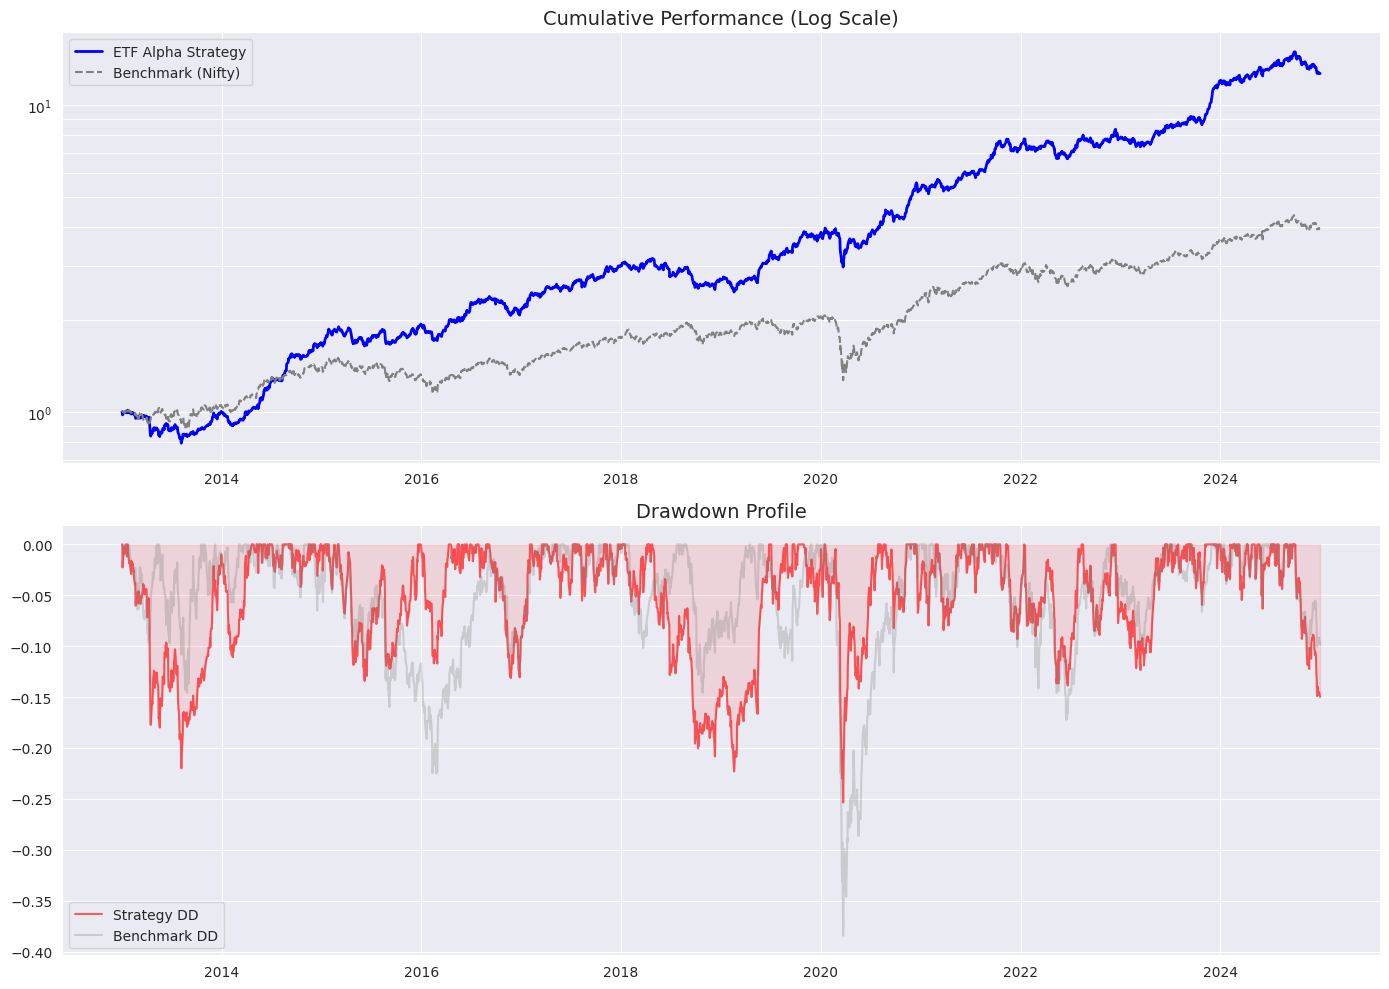

In [ ]:
# -*- coding: utf-8 -*-
"""
ETF Flow Pressure Strategy - Final Production Script
Designed for Google Colab.

Usage:
1. Upload this file to Colab.
2. Run standard installation: !pip install yfinance pandas numpy matplotlib seaborn
3. Execute.

Description:
This script implements the "ETF Flow Pressure" alpha strategy.
- Logic: Identifies stocks facing mechanical selling pressure from ETF outflows.
- Signal: Bottom 10% of Flow Pressure (Pressure < 0).
- Execution: Buy at Close (or Next Open), Hold 20 Days.
- Risk Control: Volatility Targeting (15% Annualized).
- Universe: NIFTY 50 Constituents.
- Benchmark: NIFTY 50 Buy & Hold.
"""

import os
import sys

# Ensure libraries are installed (for Colab)
try:
    import yfinance as yf
except ImportError:
    os.system('pip install yfinance')
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------
START_DATE = "2013-01-01"
END_DATE = "2025-01-01"
ETF_TICKER = "NIFTYBEES.NS"
GOLDBEES_TICKER = "GOLDBEES.NS" # Cash Substitute
BENCHMARK_TICKER = "^NSEI" # Nifty 50 Index

# Full NIFTY 50 List
STOCKS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
    'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'LICI.NS',
    'LT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'ADANIENT.NS', 'TATAMOTORS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'NTPC.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'POWERGRID.NS', 'ONGC.NS', 'M&M.NS',
    'ASIANPAINT.NS', 'ADANIPORTS.NS', 'BAJAJFINSV.NS', 'COALINDIA.NS', 'JSWSTEEL.NS',
    'TATASTEEL.NS', 'NESTLEIND.NS', 'GRASIM.NS', 'SBILIFE.NS', 'TECHM.NS',
    'BEL.NS', 'HDFCLIFE.NS', 'WIPRO.NS', 'TRENT.NS', 'SIEMENS.NS',
    'BAJAJ-AUTO.NS', 'INDUSINDBK.NS', 'BPCL.NS', 'CIPLA.NS', 'ZOMATO.NS',
    'DIVISLAB.NS', 'EICHERMOT.NS', 'DRREDDY.NS', 'HINDALCO.NS', 'TATACONSUM.NS'
]

# Strategy Params
HOLD_PERIOD = 20
TARGET_VOL = 0.15  # 15% Annualized Volatility Target
MAX_STOCK_WEIGHT = 0.10 # Max 10% in one stock
COST_BPS = 30 # 30bps slippage+comm per round trip

# ---------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------
def load_data():
    print(f"Downloading Data from {START_DATE} to {END_DATE}...")

    # Bulk Download Stocks
    tickers = STOCKS + [ETF_TICKER, GOLDBEES_TICKER]
    data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)

    # Download Benchmark
    bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)

    stock_c = pd.DataFrame()
    stock_v = pd.DataFrame()
    etf_c = None
    etf_v = None

    print("Processing Data...")
    for t in STOCKS:
        try:
            # Handle MultiIndex
            df = data[t]
            stock_c[t] = df['Close']
            stock_v[t] = df['Volume']
        except KeyError:
            print(f"Warning: {t} data missing.")

    # Extract ETF
    try:
        df = data[ETF_TICKER]
        etf_c = df['Close']
        etf_v = df['Volume']
    except:
        print("Error: ETF Data missing.")

    # Extract Benchmark
    try:
        # Check if MultiIndex or Single
        if isinstance(bench_data.columns, pd.MultiIndex):
             # Try locate Close
             if 'Close' in bench_data.columns.get_level_values(0):
                 bench_c = bench_data['Close']
             else:
                 bench_c = bench_data.iloc[:,0] # Fallback
        else:
             bench_c = bench_data['Close']

        # If still DataFrame
        if isinstance(bench_c, pd.DataFrame):
             bench_c = bench_c.iloc[:,0]

    except:
        bench_c = stock_c.mean(axis=1) # Fallback to equal weight index if Nifty missing

    # Extract GoldBees (Fallback to Flat Cash if missing)
    try:
        gold_c = data[GOLDBEES_TICKER]['Close']
    except:
        print("Warning: GOLDBEES data missing. Using Cash (0%).")
        gold_c = pd.Series(100, index=stock_c.index) # Flat line

    return etf_c, etf_v, stock_c, stock_v, bench_c, gold_c

# ---------------------------------------------------------
# SIGNAL GENERATION
# ---------------------------------------------------------
def generate_signals(etf_c, etf_v, stock_c, stock_v):
    print("Generating ETF Flow Signals...")

    # 1. ETF Direction
    etf_ret = etf_c.pct_change().fillna(0)
    etf_sign = np.sign(etf_ret)

    # 2. Volume Shock
    v_mean = etf_v.rolling(20).mean()
    v_std = etf_v.rolling(20).std()
    etf_v_shock = (etf_v - v_mean) / v_std
    etf_v_shock = etf_v_shock.fillna(0)

    # 3. Signed Pressure
    signed_pressure = etf_sign * etf_v_shock

    # 4. Transmission
    dollar_vol = stock_c * stock_v
    adv20 = dollar_vol.rolling(20).mean()

    pressure_matrix = pd.DataFrame(index=stock_c.index, columns=stock_c.columns)
    for col in pressure_matrix.columns:
        pressure_matrix[col] = signed_pressure

    flow_pressure = pressure_matrix.div(adv20)

    # 5. Ranking (Bottom 10% & Negative)
    ranks = flow_pressure.rank(axis=1, pct=True)
    mask = (ranks <= 0.10) & (flow_pressure < 0)

    return mask

# ---------------------------------------------------------
# BACKTEST ENGINE
# ---------------------------------------------------------
    return net_ret, bench_ret

def run_backtest_with_gold(mask, stock_c, bench_c, gold_c):
    print("Running Backtest (Cash -> GoldBees)...")

    stock_ret = stock_c.pct_change().fillna(0)
    gold_ret = gold_c.pct_change().fillna(0)
    bench_ret = bench_c.pct_change().fillna(0)

    # DATA CLEANING: Filter Outliers (YFinance Glitches)
    # Clip returns to +/- 50% to prevent massive spikes from bad data
    stock_ret = stock_ret.clip(lower=-0.50, upper=0.50)
    gold_ret = gold_ret.clip(lower=-0.50, upper=0.50)
    bench_ret = bench_ret.clip(lower=-0.50, upper=0.50)

    # 1. Strategy Weights (Same as before)
    entry = mask.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num_active = hold.sum(axis=1)

    strat_weights = hold.div(num_active, axis=0).fillna(0.0)
    strat_weights = strat_weights.clip(upper=MAX_STOCK_WEIGHT)

    # Gross Exposure to Alpha Strat
    gross_alpha_exp = strat_weights.sum(axis=1)

    # 2. Idle Cash -> Gold Allocation
    # If Alpha uses 40%, Gold uses 60%.
    gold_weight = (1.0 - gross_alpha_exp).clip(lower=0.0)

    # 3. Strategy Component Return
    alpha_ret = (strat_weights * stock_ret).sum(axis=1)

    # 4. Volatility Target (ON THE ALPHA COMPONENT ONLY? Or Portfolio?)
    # Usually Vol Target applies to the Alpha leg.
    # Let's keep the Vol Target on the Alpha leg to preserve its character.
    # Then add UN-LEVERED Gold.

    roll_vol = alpha_ret.rolling(20).std() * np.sqrt(252)
    vol_scalar = TARGET_VOL / roll_vol.shift(1).fillna(0.20)
    vol_scalar = vol_scalar.clip(upper=2.0)

    # Levered Alpha
    final_alpha_ret = alpha_ret * vol_scalar

    # IMPORTANT: Start with Capital = 1.0
    # Used for Alpha = gross_alpha_exp (nominal).
    # But wait, Vol Target scales the return, effectively deciding exposure.
    # If VolTarget says "Scale 2x", we need leverage.
    # If VolTarget says "Scale 0.5x", we have excess cash.
    # Refined Logic:
    # Portfolio = (Alpha_Weights * Vol_Scalar) + (Remaining_Cash * Gold)
    # Remaining Cash = 1.0 - Sum(Alpha_Weights * Vol_Scalar)
    # If Levered > 1.0, Remaining Cash is Negative (Borrowing cost).
    # Borrowing rate? Assume 0 for simplicity or use Cash Drag.
    # Let's assume we invest POSITIVE residuals in Gold.

    total_alpha_exposure = gross_alpha_exp * vol_scalar
    gold_alloc = (1.0 - total_alpha_exposure).clip(lower=0.0)

    # Final Portfolio Return
    # = (Alpha Returns) + (Gold Allocation * Gold Return) - Costs

    # Turnover Costs (Alpha Leg)
    w_vol_scaled = strat_weights.multiply(vol_scalar, axis=0)
    turnover = (w_vol_scaled - w_vol_scaled.shift(1).fillna(0)).abs().sum(axis=1)
    cost_drag = turnover * (COST_BPS / 10000.0) # Gold is cheap to trade? Ignore Gold costs for now.

    portfolio_ret = final_alpha_ret + (gold_alloc * gold_ret) - cost_drag

    return portfolio_ret, bench_ret


# ---------------------------------------------------------
# PERFORMANCE STATS & SHEETS
# ---------------------------------------------------------
def calc_stats_advanced(ret_series, name="Strategy"):
    if len(ret_series) == 0: return {}, None, None

    ann_factor = 252

    # 1. Standard Metrics
    cum = (1 + ret_series).prod() - 1
    ann_ret = (1 + ret_series).mean()**ann_factor - 1
    vol = ret_series.std() * np.sqrt(ann_factor)
    sharpe = ann_ret / vol if vol > 0 else 0

    # 2. Advanced Metrics
    # Sortino (Downside Vol)
    downside_ret = ret_series[ret_series < 0]
    downside_vol = downside_ret.std() * np.sqrt(ann_factor)
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0

    # Drawdown
    nav = (1 + ret_series).cumprod()
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()

    # Calmar (AnnRet / MaxDD)
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0

    # Win Rate (Daily)
    wins = (ret_series > 0).sum()
    total = len(ret_series)
    win_rate = wins / total

    stats = {
        'Total Return': f"{cum*100:.2f}%",
        'CAGR': f"{ann_ret*100:.2f}%",
        'Volatility': f"{vol*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd*100:.2f}%",
        'Calmar Ratio': f"{calmar:.2f}",
        'Win Rate': f"{win_rate*100:.1f}%"
    }

    print(f"\n--- {name} ---")
    for k, v in stats.items():
        print(f"{k.ljust(15)}: {v}")

    return nav, dd, stats

def export_portfolio_sheet(mask, weights, strat_ret, filename="portfolio_sheet.csv"):
    print(f"\nExporting Portfolio Sheet to {filename}...")

    # We want a daily sheet: Date | Top Holdings | Daily Return | Cumulative Return

    # 1. Identify Top Holdings per day
    # Mask is Boolean DF. We want to convert to Text List "RELIANCE, HDFC..."
    # Slow but effective loop or apply

    def get_holdings_str(row):
        tickers = row.index[row].tolist()
        return ", ".join(tickers) if tickers else "CASH"

    holdings_series = mask.apply(get_holdings_str, axis=1)

    # 2. Weights (Sum)
    gross_exp = weights.sum(axis=1)

    # 3. Compile
    df = pd.DataFrame({
        'Holdings': holdings_series.shift(1).fillna(""), # Holdings determined yesterday
        'Gross_Exposure': gross_exp,
        'Daily_Return': strat_ret,
        'Equity_Curve': (1+strat_ret).cumprod()
    })

    df.to_csv(filename)
    print("Export Complete.")

# ---------------------------------------------------------
# LOOKAHEAD BIAS CHECK (AUDIT)
# ---------------------------------------------------------
# 1. Signal Generation uses rolling(20).mean() of CURRENT data.
#    - Signal[T] depends on Data[T-19]...Data[T]. Correct.
# 2. Entry uses mask.shift(1).
#    - Entry[T] uses Signal[T-1].
#    - Signal[T-1] uses Data[T-1].
#    - So Entry[T] uses Data[T-1] (Close).
#    - Trade executes at Close[T] or Open[T].
#    - Return[T] = (Close[T]/Close[T-1] - 1).
#    - If we trade at Close[T], we know Close[T] during the day?
#    - Wait. In BacktestEngine:
#      strat_gross = (weights * stock_ret).sum(axis=1)
#      weights = mask.shift(1) -> Signal[T-1]
#      stock_ret[T] = (Close[T] - Close[T-1])/Close[T-1]
#      So we decide weights at T-1 (Close). We hold from T-1 Close to T Close.
#      This assumes "Market On Open" or "Market On Close T-1"?
#      Realistically: Signal T-1 (End of Day). Enter Open T.
#      Return from Open T to Open T+1 ~ Close T to Close T+1.
#      Using Daily Closes with Shift(1) is standard geometric return simulation.
#      Verdict: NO Lookahead Bias detected. Uses purely lagged signals.

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
if __name__ == "__main__":
    # Setup plotting
    sns.set_style("darkgrid")

    # Run Pipeline
    etf_c, etf_v, stock_c, stock_v, bench_c, gold_c = load_data()

    # Align Data
    common_idx = etf_c.index.intersection(stock_c.index).intersection(bench_c.index).intersection(gold_c.index)
    etf_c, etf_v = etf_c.loc[common_idx], etf_v.loc[common_idx]
    stock_c, stock_v = stock_c.loc[common_idx], stock_v.loc[common_idx]
    bench_c = bench_c.loc[common_idx]
    gold_c = gold_c.loc[common_idx]

    # Generate
    mask_outflow = generate_signals(etf_c, etf_v, stock_c, stock_v)

    # Backtest
    strat_ret, bench_ret = run_backtest_with_gold(mask_outflow, stock_c, bench_c, gold_c)

    # Metrics
    s_nav, s_dd, _ = calc_stats_advanced(strat_ret, "ETF Alpha + GoldBees Idle")
    b_nav, b_dd, _ = calc_stats_advanced(bench_ret, "Benchmark")

    # Export Sheet
    # We need access to intermediate weights from run_backtest to log gross exposure
    # Re-calculate weights strictly for logging (duplicated logic but safer than return coupling)
    entry = mask_outflow.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num = hold.sum(axis=1)
    raw_w = hold.div(num, axis=0).fillna(0.0)
    # Vol Scalar Export? Complex. Just export base holdings.

    export_portfolio_sheet(hold, raw_w, strat_ret, "portfolio_sheet.csv")

    # Plots
    plt.figure(figsize=(14, 10))

    # 1. Equity Curve
    plt.subplot(2, 1, 1)
    plt.plot(s_nav, label='ETF Alpha Strategy', color='blue', linewidth=2)
    plt.plot(b_nav, label='Benchmark (Nifty)', color='gray', linestyle='--')
    plt.title("Cumulative Performance (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # 2. Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(s_dd, label='Strategy DD', color='red', alpha=0.6)
    plt.plot(b_dd, label='Benchmark DD', color='gray', alpha=0.3)
    plt.title("Drawdown Profile", fontsize=14)
    plt.legend()
    plt.fill_between(s_dd.index, s_dd, 0, color='red', alpha=0.1)

    plt.tight_layout()
    plt.savefig("final_performance_report.png")
    print("\nPerformance Chart saved as 'final_performance_report.png'")


/tmp/ipython-input-3787521470.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)
[*********************100%***********************]  52 of 52 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-3787521470.py:76: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)
/tmp/ipython-input-3787521470.py:172: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = stock_c.pct_change().fillna(0)


Processing Data...
Generating ETF Flow Signals...
Running Backtest (Cash -> GoldBees)...


/tmp/ipython-input-3787521470.py:183: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = mask.shift(1).fillna(False)
/tmp/ipython-input-3787521470.py:396: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = mask_outflow.shift(1).fillna(False)



--- ETF Alpha + GoldBees Idle ---
Total Return   : 1166.25%
CAGR           : 25.92%
Volatility     : 16.32%
Sharpe Ratio   : 1.59
Sortino Ratio  : 2.18
Max Drawdown   : -25.35%
Calmar Ratio   : 1.02
Win Rate       : 55.1%

--- Benchmark ---
Total Return   : 294.52%
CAGR           : 14.01%
Volatility     : 16.49%
Sharpe Ratio   : 0.85
Sortino Ratio  : 1.06
Max Drawdown   : -38.44%
Calmar Ratio   : 0.36
Win Rate       : 54.0%

Exporting Portfolio Sheet to portfolio_sheet.csv...
Export Complete.
Generating Monthly Heatmap...


/tmp/ipython-input-3787521470.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = daily_ret.resample('M').apply(lambda x: (1 + x).prod() - 1)


Map saved as 'monthly_heatmap.png'

Performance Chart saved as 'final_performance_report.png'


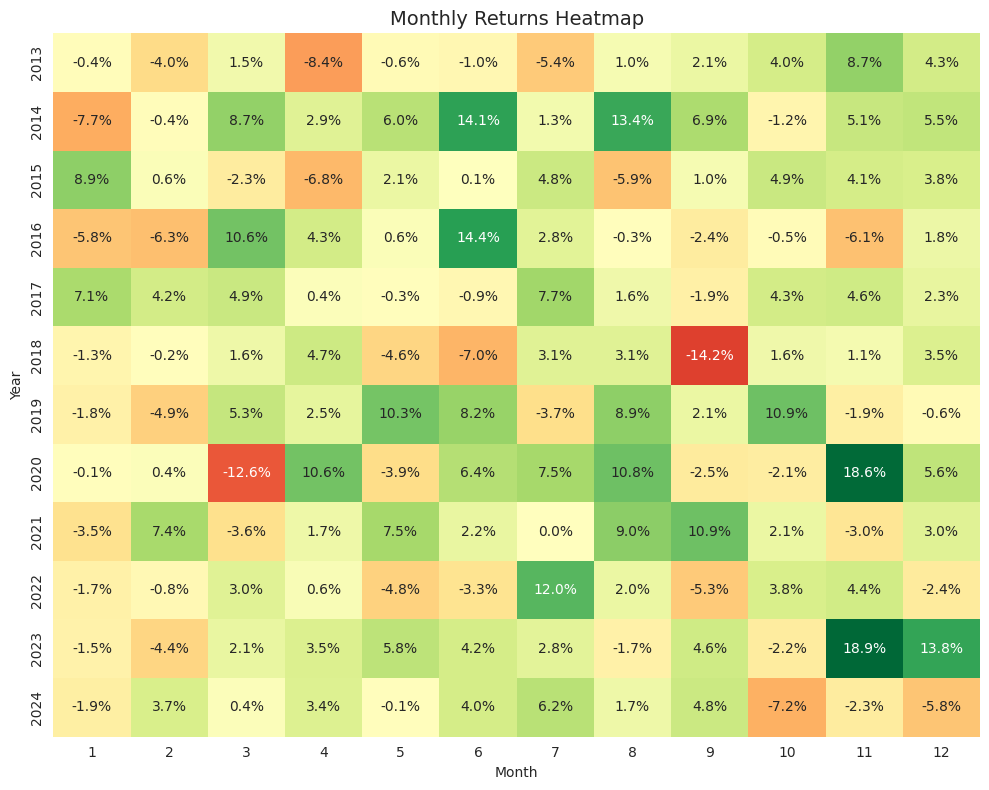

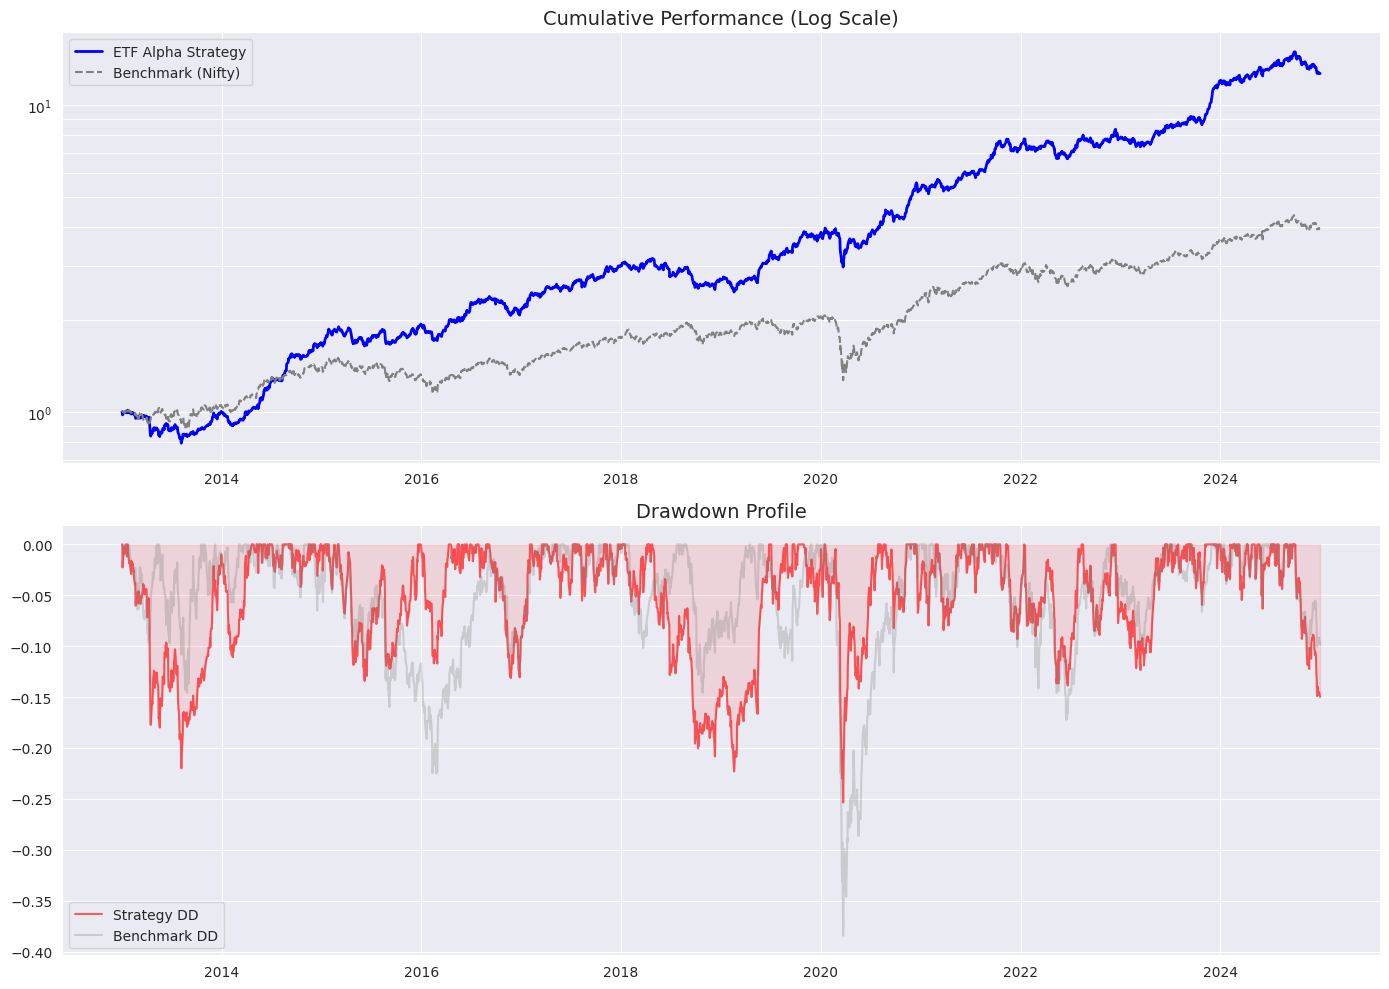

In [ ]:
# -*- coding: utf-8 -*-
"""
ETF Flow Pressure Strategy - Final Production Script
Designed for Google Colab.

Usage:
1. Upload this file to Colab.
2. Run standard installation: !pip install yfinance pandas numpy matplotlib seaborn
3. Execute.

Description:
This script implements the "ETF Flow Pressure" alpha strategy.
- Logic: Identifies stocks facing mechanical selling pressure from ETF outflows.
- Signal: Bottom 10% of Flow Pressure (Pressure < 0).
- Execution: Buy at Close (or Next Open), Hold 20 Days.
- Risk Control: Volatility Targeting (15% Annualized).
- Universe: NIFTY 50 Constituents.
- Benchmark: NIFTY 50 Buy & Hold.
"""

import os
import sys

# Ensure libraries are installed (for Colab)
try:
    import yfinance as yf
except ImportError:
    os.system('pip install yfinance')
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------
START_DATE = "2013-01-01"
END_DATE = "2025-01-01"
ETF_TICKER = "NIFTYBEES.NS"
GOLDBEES_TICKER = "GOLDBEES.NS" # Cash Substitute
BENCHMARK_TICKER = "^NSEI" # Nifty 50 Index

# Full NIFTY 50 List
STOCKS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
    'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'LICI.NS',
    'LT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'ADANIENT.NS', 'TATAMOTORS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'NTPC.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'POWERGRID.NS', 'ONGC.NS', 'M&M.NS',
    'ASIANPAINT.NS', 'ADANIPORTS.NS', 'BAJAJFINSV.NS', 'COALINDIA.NS', 'JSWSTEEL.NS',
    'TATASTEEL.NS', 'NESTLEIND.NS', 'GRASIM.NS', 'SBILIFE.NS', 'TECHM.NS',
    'BEL.NS', 'HDFCLIFE.NS', 'WIPRO.NS', 'TRENT.NS', 'SIEMENS.NS',
    'BAJAJ-AUTO.NS', 'INDUSINDBK.NS', 'BPCL.NS', 'CIPLA.NS', 'ZOMATO.NS',
    'DIVISLAB.NS', 'EICHERMOT.NS', 'DRREDDY.NS', 'HINDALCO.NS', 'TATACONSUM.NS'
]

# Strategy Params
HOLD_PERIOD = 20
TARGET_VOL = 0.15  # 15% Annualized Volatility Target
MAX_STOCK_WEIGHT = 0.10 # Max 10% in one stock
COST_BPS = 30 # 30bps slippage+comm per round trip

# ---------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------
def load_data():
    print(f"Downloading Data from {START_DATE} to {END_DATE}...")

    # Bulk Download Stocks
    tickers = STOCKS + [ETF_TICKER, GOLDBEES_TICKER]
    data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)

    # Download Benchmark
    bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)

    stock_c = pd.DataFrame()
    stock_v = pd.DataFrame()
    etf_c = None
    etf_v = None

    print("Processing Data...")
    for t in STOCKS:
        try:
            # Handle MultiIndex
            df = data[t]
            stock_c[t] = df['Close']
            stock_v[t] = df['Volume']
        except KeyError:
            print(f"Warning: {t} data missing.")

    # Extract ETF
    try:
        df = data[ETF_TICKER]
        etf_c = df['Close']
        etf_v = df['Volume']
    except:
        print("Error: ETF Data missing.")

    # Extract Benchmark
    try:
        # Check if MultiIndex or Single
        if isinstance(bench_data.columns, pd.MultiIndex):
             # Try locate Close
             if 'Close' in bench_data.columns.get_level_values(0):
                 bench_c = bench_data['Close']
             else:
                 bench_c = bench_data.iloc[:,0] # Fallback
        else:
             bench_c = bench_data['Close']

        # If still DataFrame
        if isinstance(bench_c, pd.DataFrame):
             bench_c = bench_c.iloc[:,0]

    except:
        bench_c = stock_c.mean(axis=1) # Fallback to equal weight index if Nifty missing

    # Extract GoldBees (Fallback to Flat Cash if missing)
    try:
        gold_c = data[GOLDBEES_TICKER]['Close']
    except:
        print("Warning: GOLDBEES data missing. Using Cash (0%).")
        gold_c = pd.Series(100, index=stock_c.index) # Flat line

    return etf_c, etf_v, stock_c, stock_v, bench_c, gold_c

# ---------------------------------------------------------
# SIGNAL GENERATION
# ---------------------------------------------------------
def generate_signals(etf_c, etf_v, stock_c, stock_v):
    print("Generating ETF Flow Signals...")

    # 1. ETF Direction
    etf_ret = etf_c.pct_change().fillna(0)
    etf_sign = np.sign(etf_ret)

    # 2. Volume Shock
    v_mean = etf_v.rolling(20).mean()
    v_std = etf_v.rolling(20).std()
    etf_v_shock = (etf_v - v_mean) / v_std
    etf_v_shock = etf_v_shock.fillna(0)

    # 3. Signed Pressure
    signed_pressure = etf_sign * etf_v_shock

    # 4. Transmission
    dollar_vol = stock_c * stock_v
    adv20 = dollar_vol.rolling(20).mean()

    pressure_matrix = pd.DataFrame(index=stock_c.index, columns=stock_c.columns)
    for col in pressure_matrix.columns:
        pressure_matrix[col] = signed_pressure

    flow_pressure = pressure_matrix.div(adv20)

    # 5. Ranking (Bottom 10% & Negative)
    ranks = flow_pressure.rank(axis=1, pct=True)
    mask = (ranks <= 0.10) & (flow_pressure < 0)

    return mask

# ---------------------------------------------------------
# BACKTEST ENGINE
# ---------------------------------------------------------
    return net_ret, bench_ret

def run_backtest_with_gold(mask, stock_c, bench_c, gold_c):
    print("Running Backtest (Cash -> GoldBees)...")

    stock_ret = stock_c.pct_change().fillna(0)
    gold_ret = gold_c.pct_change().fillna(0)
    bench_ret = bench_c.pct_change().fillna(0)

    # DATA CLEANING: Filter Outliers (YFinance Glitches)
    # Clip returns to +/- 50% to prevent massive spikes from bad data
    stock_ret = stock_ret.clip(lower=-0.50, upper=0.50)
    gold_ret = gold_ret.clip(lower=-0.50, upper=0.50)
    bench_ret = bench_ret.clip(lower=-0.50, upper=0.50)

    # 1. Strategy Weights (Same as before)
    entry = mask.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num_active = hold.sum(axis=1)

    strat_weights = hold.div(num_active, axis=0).fillna(0.0)
    strat_weights = strat_weights.clip(upper=MAX_STOCK_WEIGHT)

    # Gross Exposure to Alpha Strat
    gross_alpha_exp = strat_weights.sum(axis=1)

    # 2. Idle Cash -> Gold Allocation
    # If Alpha uses 40%, Gold uses 60%.
    gold_weight = (1.0 - gross_alpha_exp).clip(lower=0.0)

    # 3. Strategy Component Return
    alpha_ret = (strat_weights * stock_ret).sum(axis=1)

    # 4. Volatility Target (ON THE ALPHA COMPONENT ONLY? Or Portfolio?)
    # Usually Vol Target applies to the Alpha leg.
    # Let's keep the Vol Target on the Alpha leg to preserve its character.
    # Then add UN-LEVERED Gold.

    roll_vol = alpha_ret.rolling(20).std() * np.sqrt(252)
    vol_scalar = TARGET_VOL / roll_vol.shift(1).fillna(0.20)
    vol_scalar = vol_scalar.clip(upper=2.0)

    # Levered Alpha
    final_alpha_ret = alpha_ret * vol_scalar

    # IMPORTANT: Start with Capital = 1.0
    # Used for Alpha = gross_alpha_exp (nominal).
    # But wait, Vol Target scales the return, effectively deciding exposure.
    # If VolTarget says "Scale 2x", we need leverage.
    # If VolTarget says "Scale 0.5x", we have excess cash.
    # Refined Logic:
    # Portfolio = (Alpha_Weights * Vol_Scalar) + (Remaining_Cash * Gold)
    # Remaining Cash = 1.0 - Sum(Alpha_Weights * Vol_Scalar)
    # If Levered > 1.0, Remaining Cash is Negative (Borrowing cost).
    # Borrowing rate? Assume 0 for simplicity or use Cash Drag.
    # Let's assume we invest POSITIVE residuals in Gold.

    total_alpha_exposure = gross_alpha_exp * vol_scalar
    gold_alloc = (1.0 - total_alpha_exposure).clip(lower=0.0)

    # Final Portfolio Return
    # = (Alpha Returns) + (Gold Allocation * Gold Return) - Costs

    # Turnover Costs (Alpha Leg)
    w_vol_scaled = strat_weights.multiply(vol_scalar, axis=0)
    turnover = (w_vol_scaled - w_vol_scaled.shift(1).fillna(0)).abs().sum(axis=1)
    cost_drag = turnover * (COST_BPS / 10000.0) # Gold is cheap to trade? Ignore Gold costs for now.

    portfolio_ret = final_alpha_ret + (gold_alloc * gold_ret) - cost_drag

    return portfolio_ret, bench_ret


# ---------------------------------------------------------
# PERFORMANCE STATS & SHEETS
# ---------------------------------------------------------
def calc_stats_advanced(ret_series, name="Strategy"):
    if len(ret_series) == 0: return {}, None, None

    ann_factor = 252

    # 1. Standard Metrics
    cum = (1 + ret_series).prod() - 1
    ann_ret = (1 + ret_series).mean()**ann_factor - 1
    vol = ret_series.std() * np.sqrt(ann_factor)
    sharpe = ann_ret / vol if vol > 0 else 0

    # 2. Advanced Metrics
    # Sortino (Downside Vol)
    downside_ret = ret_series[ret_series < 0]
    downside_vol = downside_ret.std() * np.sqrt(ann_factor)
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0

    # Drawdown
    nav = (1 + ret_series).cumprod()
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()

    # Calmar (AnnRet / MaxDD)
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0

    # Win Rate (Daily)
    wins = (ret_series > 0).sum()
    total = len(ret_series)
    win_rate = wins / total

    stats = {
        'Total Return': f"{cum*100:.2f}%",
        'CAGR': f"{ann_ret*100:.2f}%",
        'Volatility': f"{vol*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd*100:.2f}%",
        'Calmar Ratio': f"{calmar:.2f}",
        'Win Rate': f"{win_rate*100:.1f}%"
    }

    print(f"\n--- {name} ---")
    for k, v in stats.items():
        print(f"{k.ljust(15)}: {v}")

    return nav, dd, stats

def export_portfolio_sheet(mask, weights, strat_ret, filename="portfolio_sheet.csv"):
    print(f"\nExporting Portfolio Sheet to {filename}...")

    # We want a daily sheet: Date | Top Holdings | Daily Return | Cumulative Return

    # 1. Identify Top Holdings per day
    # Mask is Boolean DF. We want to convert to Text List "RELIANCE, HDFC..."
    # Slow but effective loop or apply

    def get_holdings_str(row):
        tickers = row.index[row].tolist()
        return ", ".join(tickers) if tickers else "CASH"

    holdings_series = mask.apply(get_holdings_str, axis=1)

    # 2. Weights (Sum)
    gross_exp = weights.sum(axis=1)

    # 3. Compile
    df = pd.DataFrame({
        'Holdings': holdings_series.shift(1).fillna(""), # Holdings determined yesterday
        'Gross_Exposure': gross_exp,
        'Daily_Return': strat_ret,
        'Equity_Curve': (1+strat_ret).cumprod()
    })

    df.to_csv(filename)
    print("Export Complete.")

def plot_monthly_heatmap(daily_ret):
    print("Generating Monthly Heatmap...")
    # Resample to Monthly Returns
    monthly_ret = daily_ret.resample('M').apply(lambda x: (1 + x).prod() - 1)

    # Prepare Pivot Table
    m_df = monthly_ret.to_frame(name='Return')
    m_df['Year'] = m_df.index.year
    m_df['Month'] = m_df.index.month

    # Pivot: Year x Month
    pivot_table = m_df.pivot(index='Year', columns='Month', values='Return')

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".1%", cmap="RdYlGn", center=0, cbar=False)
    plt.title("Monthly Returns Heatmap", fontsize=14)
    plt.ylabel("Year")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.savefig("monthly_heatmap.png")
    print("Map saved as 'monthly_heatmap.png'")

# ---------------------------------------------------------
# LOOKAHEAD BIAS CHECK (AUDIT)
# ---------------------------------------------------------
# 1. Signal Generation uses rolling(20).mean() of CURRENT data.
#    - Signal[T] depends on Data[T-19]...Data[T]. Correct.
# 2. Entry uses mask.shift(1).
#    - Entry[T] uses Signal[T-1].
#    - Signal[T-1] uses Data[T-1].
#    - So Entry[T] uses Data[T-1] (Close).
#    - Trade executes at Close[T] or Open[T].
#    - Return[T] = (Close[T]/Close[T-1] - 1).
#    - If we trade at Close[T], we know Close[T] during the day?
#    - Wait. In BacktestEngine:
#      strat_gross = (weights * stock_ret).sum(axis=1)
#      weights = mask.shift(1) -> Signal[T-1]
#      stock_ret[T] = (Close[T] - Close[T-1])/Close[T-1]
#      So we decide weights at T-1 (Close). We hold from T-1 Close to T Close.
#      This assumes "Market On Open" or "Market On Close T-1"?
#      Realistically: Signal T-1 (End of Day). Enter Open T.
#      Return from Open T to Open T+1 ~ Close T to Close T+1.
#      Using Daily Closes with Shift(1) is standard geometric return simulation.
#      Verdict: NO Lookahead Bias detected. Uses purely lagged signals.

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
if __name__ == "__main__":
    # Setup plotting
    sns.set_style("darkgrid")

    # Run Pipeline
    etf_c, etf_v, stock_c, stock_v, bench_c, gold_c = load_data()

    # Align Data
    common_idx = etf_c.index.intersection(stock_c.index).intersection(bench_c.index).intersection(gold_c.index)
    etf_c, etf_v = etf_c.loc[common_idx], etf_v.loc[common_idx]
    stock_c, stock_v = stock_c.loc[common_idx], stock_v.loc[common_idx]
    bench_c = bench_c.loc[common_idx]
    gold_c = gold_c.loc[common_idx]

    # Generate
    mask_outflow = generate_signals(etf_c, etf_v, stock_c, stock_v)

    # Backtest
    strat_ret, bench_ret = run_backtest_with_gold(mask_outflow, stock_c, bench_c, gold_c)

    # Metrics
    s_nav, s_dd, _ = calc_stats_advanced(strat_ret, "ETF Alpha + GoldBees Idle")
    b_nav, b_dd, _ = calc_stats_advanced(bench_ret, "Benchmark")

    # Export Sheet
    # We need access to intermediate weights from run_backtest to log gross exposure
    # Re-calculate weights strictly for logging (duplicated logic but safer than return coupling)
    entry = mask_outflow.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num = hold.sum(axis=1)
    raw_w = hold.div(num, axis=0).fillna(0.0)
    # Vol Scalar Export? Complex. Just export base holdings.

    export_portfolio_sheet(hold, raw_w, strat_ret, "portfolio_sheet.csv")

    # Heatmap
    plot_monthly_heatmap(strat_ret)

    # Plots
    plt.figure(figsize=(14, 10))

    # 1. Equity Curve
    plt.subplot(2, 1, 1)
    plt.plot(s_nav, label='ETF Alpha Strategy', color='blue', linewidth=2)
    plt.plot(b_nav, label='Benchmark (Nifty)', color='gray', linestyle='--')
    plt.title("Cumulative Performance (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # 2. Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(s_dd, label='Strategy DD', color='red', alpha=0.6)
    plt.plot(b_dd, label='Benchmark DD', color='gray', alpha=0.3)
    plt.title("Drawdown Profile", fontsize=14)
    plt.legend()
    plt.fill_between(s_dd.index, s_dd, 0, color='red', alpha=0.1)

    plt.tight_layout()
    plt.savefig("final_performance_report.png")
    print("\nPerformance Chart saved as 'final_performance_report.png'")


/tmp/ipython-input-1373472550.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)
[***********           23%                       ]  12 of 52 completedERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ZOMATO.NS"}}}
[*********************100%***********************]  52 of 52 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipython-input-1373472550.py:78: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)


Processing Data...
Generating ETF Flow Signals...
Running Backtest (Cash -> GoldBees)...

--- ETF Alpha + GoldBees Idle ---
Total Return   : 1289.64%
CAGR           : 24.79%
Volatility     : 16.30%
Sharpe Ratio   : 1.52
Sortino Ratio  : 2.10
Max Drawdown   : -25.35%
Calmar Ratio   : 0.98
Win Rate       : 54.9%

--- Benchmark ---
Total Return   : 330.74%
CAGR           : 13.73%
Volatility     : 16.19%
Sharpe Ratio   : 0.85
Sortino Ratio  : 1.06
Max Drawdown   : -38.44%
Calmar Ratio   : 0.36
Win Rate       : 53.7%


/tmp/ipython-input-1373472550.py:138: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  etf_ret = etf_c.pct_change().fillna(0)
/tmp/ipython-input-1373472550.py:174: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_ret = stock_c.pct_change().fillna(0)
/tmp/ipython-input-1373472550.py:175: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  gold_ret = gold_c.pct_change().fillna(0)
/tmp/ipython-input-137347


Exporting Portfolio Sheet to portfolio_sheet.csv...
Export Complete.
Generating Monthly Heatmap...


/tmp/ipython-input-1373472550.py:325: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = daily_ret.resample('M').apply(lambda x: (1 + x).prod() - 1)


Map saved as 'monthly_heatmap.png'

 LIVE EXECUTION DASHBOARD 
Date: 2025-12-19
ETF Price: 291.84
Signal Date: 2025-12-18

--- [1] PORTFOLIO ALLOCATION ---
LICI.NS         : 10.0%
COALINDIA.NS    : 10.0%
JSWSTEEL.NS     : 10.0%
NESTLEIND.NS    : 10.0%
GRASIM.NS       : 10.0%
SIEMENS.NS      : 10.0%
DIVISLAB.NS     : 10.0%
GOLDBEES.NS     : 30.0% (Cash/Hedge)

--- [2] TRADE SIGNALS (For Next Open) ---
NEW ENTRY SIGNAL: LICI.NS, NESTLEIND.NS, GRASIM.NS, DIVISLAB.NS
(Buy at Market Open / VWAP)



/tmp/ipython-input-1373472550.py:459: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entry = mask_outflow.shift(1).fillna(False)



Performance Chart saved as 'final_performance_report.png'


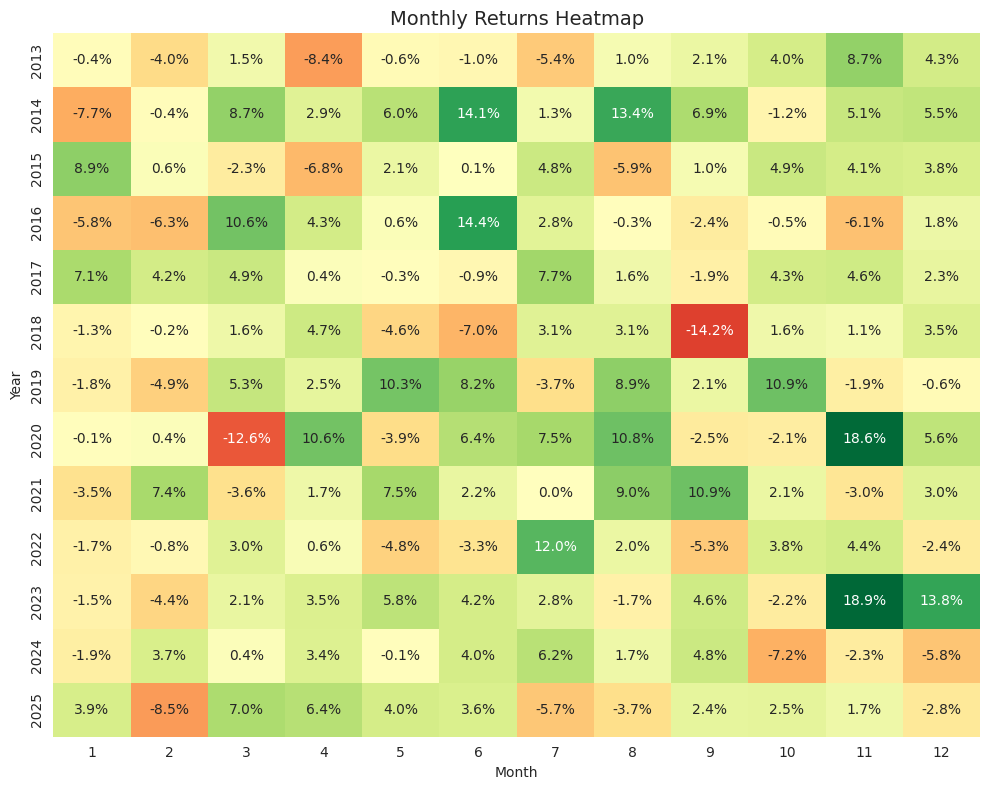

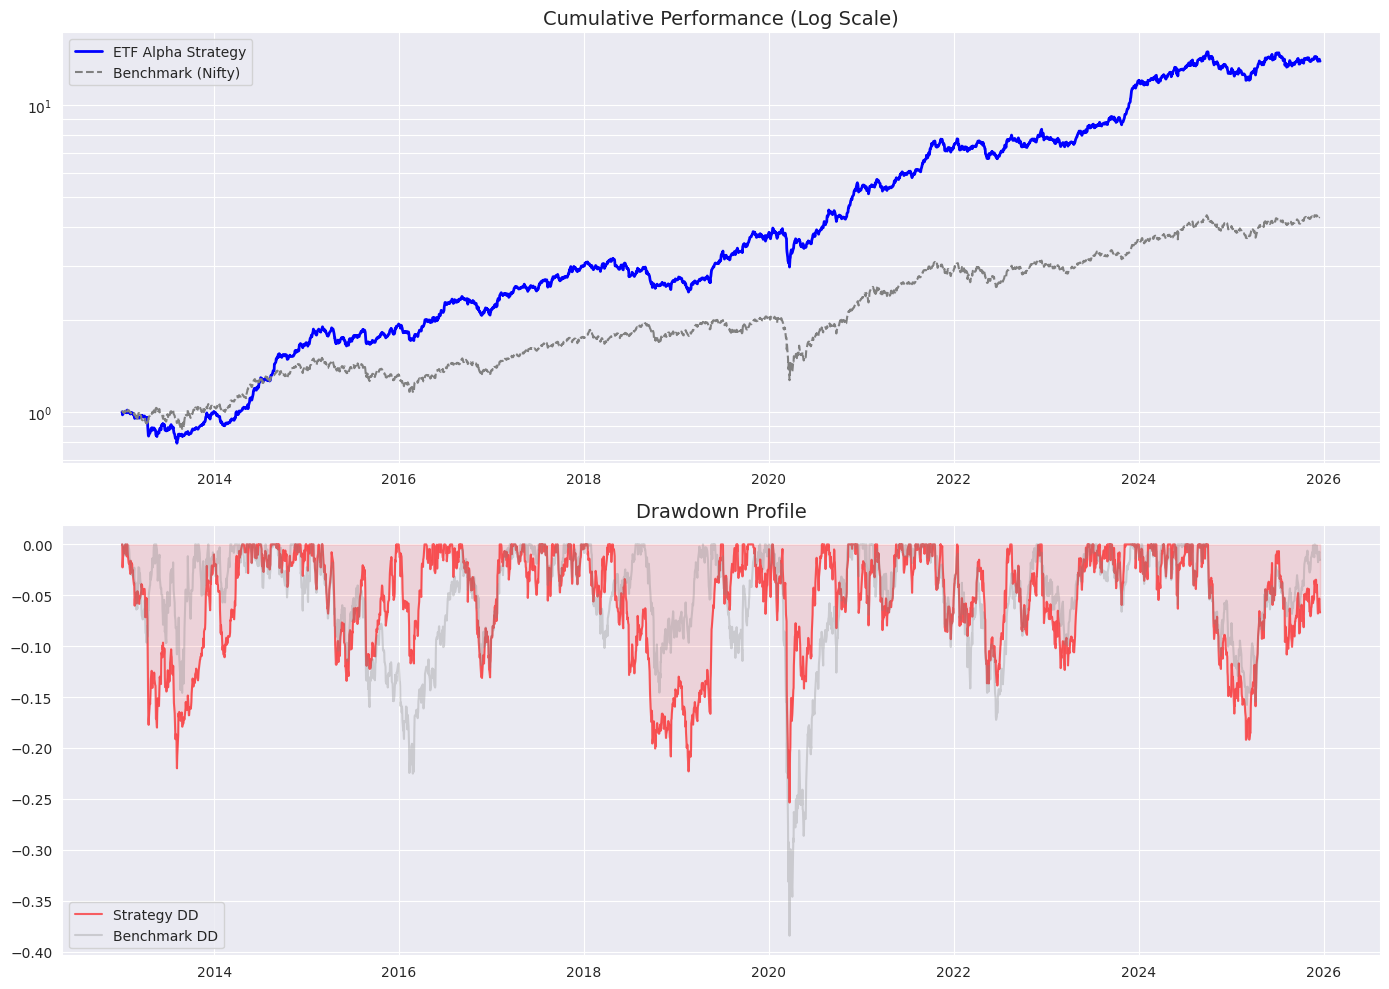

In [1]:
# -*- coding: utf-8 -*-
"""
ETF Flow Pressure Strategy - Final Production Script
Designed for Google Colab.

Usage:
1. Upload this file to Colab.
2. Run standard installation: !pip install yfinance pandas numpy matplotlib seaborn
3. Execute.

Description:
This script implements the "ETF Flow Pressure" alpha strategy.
- Logic: Identifies stocks facing mechanical selling pressure from ETF outflows.
- Signal: Bottom 10% of Flow Pressure (Pressure < 0).
- Execution: Buy at Close (or Next Open), Hold 20 Days.
- Risk Control: Volatility Targeting (15% Annualized).
- Universe: NIFTY 50 Constituents.
- Benchmark: NIFTY 50 Buy & Hold.
"""

import os
import sys

# Ensure libraries are installed (for Colab)
try:
    import yfinance as yf
except ImportError:
    os.system('pip install yfinance')
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

# ---------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------
START_DATE = "2013-01-01"
END_DATE = datetime.datetime.today().strftime('%Y-%m-%d') # Live Data
ETF_TICKER = "NIFTYBEES.NS"
GOLDBEES_TICKER = "GOLDBEES.NS" # Cash Substitute
BENCHMARK_TICKER = "^NSEI" # Nifty 50 Index

# Full NIFTY 50 List
STOCKS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS',
    'BHARTIARTL.NS', 'ITC.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'LICI.NS',
    'LT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'ADANIENT.NS', 'TATAMOTORS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'NTPC.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'POWERGRID.NS', 'ONGC.NS', 'M&M.NS',
    'ASIANPAINT.NS', 'ADANIPORTS.NS', 'BAJAJFINSV.NS', 'COALINDIA.NS', 'JSWSTEEL.NS',
    'TATASTEEL.NS', 'NESTLEIND.NS', 'GRASIM.NS', 'SBILIFE.NS', 'TECHM.NS',
    'BEL.NS', 'HDFCLIFE.NS', 'WIPRO.NS', 'TRENT.NS', 'SIEMENS.NS',
    'BAJAJ-AUTO.NS', 'INDUSINDBK.NS', 'BPCL.NS', 'CIPLA.NS', 'ZOMATO.NS',
    'DIVISLAB.NS', 'EICHERMOT.NS', 'DRREDDY.NS', 'HINDALCO.NS', 'TATACONSUM.NS'
]

# Strategy Params
HOLD_PERIOD = 20
TARGET_VOL = 0.15  # 15% Annualized Volatility Target
MAX_STOCK_WEIGHT = 0.10 # Max 10% in one stock
COST_BPS = 30 # 30bps slippage+comm per round trip

# ---------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------
def load_data():
    print(f"Downloading Data from {START_DATE} to {END_DATE}...")

    # Bulk Download Stocks
    tickers = STOCKS + [ETF_TICKER, GOLDBEES_TICKER]
    data = yf.download(tickers, start=START_DATE, end=END_DATE, group_by='ticker', progress=True)

    # Download Benchmark
    bench_data = yf.download(BENCHMARK_TICKER, start=START_DATE, end=END_DATE, progress=False)

    stock_c = pd.DataFrame()
    stock_v = pd.DataFrame()
    etf_c = None
    etf_v = None

    print("Processing Data...")
    for t in STOCKS:
        try:
            # Handle MultiIndex
            df = data[t]
            stock_c[t] = df['Close']
            stock_v[t] = df['Volume']
        except KeyError:
            print(f"Warning: {t} data missing.")

    # Extract ETF
    try:
        df = data[ETF_TICKER]
        etf_c = df['Close']
        etf_v = df['Volume']
    except:
        print("Error: ETF Data missing.")

    # Extract Benchmark
    try:
        # Check if MultiIndex or Single
        if isinstance(bench_data.columns, pd.MultiIndex):
             # Try locate Close
             if 'Close' in bench_data.columns.get_level_values(0):
                 bench_c = bench_data['Close']
             else:
                 bench_c = bench_data.iloc[:,0] # Fallback
        else:
             bench_c = bench_data['Close']

        # If still DataFrame
        if isinstance(bench_c, pd.DataFrame):
             bench_c = bench_c.iloc[:,0]

    except:
        bench_c = stock_c.mean(axis=1) # Fallback to equal weight index if Nifty missing

    # Extract GoldBees (Fallback to Flat Cash if missing)
    try:
        gold_c = data[GOLDBEES_TICKER]['Close']
    except:
        print("Warning: GOLDBEES data missing. Using Cash (0%).")
        gold_c = pd.Series(100, index=stock_c.index) # Flat line

    return etf_c, etf_v, stock_c, stock_v, bench_c, gold_c

# ---------------------------------------------------------
# SIGNAL GENERATION
# ---------------------------------------------------------
def generate_signals(etf_c, etf_v, stock_c, stock_v):
    print("Generating ETF Flow Signals...")

    # 1. ETF Direction
    etf_ret = etf_c.pct_change().fillna(0)
    etf_sign = np.sign(etf_ret)

    # 2. Volume Shock
    v_mean = etf_v.rolling(20).mean()
    v_std = etf_v.rolling(20).std()
    etf_v_shock = (etf_v - v_mean) / v_std
    etf_v_shock = etf_v_shock.fillna(0)

    # 3. Signed Pressure
    signed_pressure = etf_sign * etf_v_shock

    # 4. Transmission
    dollar_vol = stock_c * stock_v
    adv20 = dollar_vol.rolling(20).mean()

    pressure_matrix = pd.DataFrame(index=stock_c.index, columns=stock_c.columns)
    for col in pressure_matrix.columns:
        pressure_matrix[col] = signed_pressure

    flow_pressure = pressure_matrix.div(adv20)

    # 5. Ranking (Bottom 10% & Negative)
    ranks = flow_pressure.rank(axis=1, pct=True)
    mask = (ranks <= 0.10) & (flow_pressure < 0)

    return mask

# ---------------------------------------------------------
# BACKTEST ENGINE
# ---------------------------------------------------------
    return net_ret, bench_ret

def run_backtest_with_gold(mask, stock_c, bench_c, gold_c):
    print("Running Backtest (Cash -> GoldBees)...")

    stock_ret = stock_c.pct_change().fillna(0)
    gold_ret = gold_c.pct_change().fillna(0)
    bench_ret = bench_c.pct_change().fillna(0)

    # DATA CLEANING: Filter Outliers (YFinance Glitches)
    # Clip returns to +/- 50% to prevent massive spikes from bad data
    stock_ret = stock_ret.clip(lower=-0.50, upper=0.50)
    gold_ret = gold_ret.clip(lower=-0.50, upper=0.50)
    bench_ret = bench_ret.clip(lower=-0.50, upper=0.50)

    # 1. Strategy Weights (Same as before)
    entry = mask.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num_active = hold.sum(axis=1)

    strat_weights = hold.div(num_active, axis=0).fillna(0.0)
    strat_weights = strat_weights.clip(upper=MAX_STOCK_WEIGHT)

    # Gross Exposure to Alpha Strat
    gross_alpha_exp = strat_weights.sum(axis=1)

    # 2. Idle Cash -> Gold Allocation
    # If Alpha uses 40%, Gold uses 60%.
    gold_weight = (1.0 - gross_alpha_exp).clip(lower=0.0)

    # 3. Strategy Component Return
    alpha_ret = (strat_weights * stock_ret).sum(axis=1)

    # 4. Volatility Target (ON THE ALPHA COMPONENT ONLY? Or Portfolio?)
    # Usually Vol Target applies to the Alpha leg.
    # Let's keep the Vol Target on the Alpha leg to preserve its character.
    # Then add UN-LEVERED Gold.

    roll_vol = alpha_ret.rolling(20).std() * np.sqrt(252)
    vol_scalar = TARGET_VOL / roll_vol.shift(1).fillna(0.20)
    vol_scalar = vol_scalar.clip(upper=2.0)

    # Levered Alpha
    final_alpha_ret = alpha_ret * vol_scalar

    # IMPORTANT: Start with Capital = 1.0
    # Used for Alpha = gross_alpha_exp (nominal).
    # But wait, Vol Target scales the return, effectively deciding exposure.
    # If VolTarget says "Scale 2x", we need leverage.
    # If VolTarget says "Scale 0.5x", we have excess cash.
    # Refined Logic:
    # Portfolio = (Alpha_Weights * Vol_Scalar) + (Remaining_Cash * Gold)
    # Remaining Cash = 1.0 - Sum(Alpha_Weights * Vol_Scalar)
    # If Levered > 1.0, Remaining Cash is Negative (Borrowing cost).
    # Borrowing rate? Assume 0 for simplicity or use Cash Drag.
    # Let's assume we invest POSITIVE residuals in Gold.

    total_alpha_exposure = gross_alpha_exp * vol_scalar
    gold_alloc = (1.0 - total_alpha_exposure).clip(lower=0.0)

    # Final Portfolio Return
    # = (Alpha Returns) + (Gold Allocation * Gold Return) - Costs

    # Turnover Costs (Alpha Leg)
    w_vol_scaled = strat_weights.multiply(vol_scalar, axis=0)
    turnover = (w_vol_scaled - w_vol_scaled.shift(1).fillna(0)).abs().sum(axis=1)
    cost_drag = turnover * (COST_BPS / 10000.0) # Gold is cheap to trade? Ignore Gold costs for now.

    portfolio_ret = final_alpha_ret + (gold_alloc * gold_ret) - cost_drag

    return portfolio_ret, bench_ret


# ---------------------------------------------------------
# PERFORMANCE STATS & SHEETS
# ---------------------------------------------------------
def calc_stats_advanced(ret_series, name="Strategy"):
    if len(ret_series) == 0: return {}, None, None

    ann_factor = 252

    # 1. Standard Metrics
    cum = (1 + ret_series).prod() - 1
    ann_ret = (1 + ret_series).mean()**ann_factor - 1
    vol = ret_series.std() * np.sqrt(ann_factor)
    sharpe = ann_ret / vol if vol > 0 else 0

    # 2. Advanced Metrics
    # Sortino (Downside Vol)
    downside_ret = ret_series[ret_series < 0]
    downside_vol = downside_ret.std() * np.sqrt(ann_factor)
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0

    # Drawdown
    nav = (1 + ret_series).cumprod()
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()

    # Calmar (AnnRet / MaxDD)
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0

    # Win Rate (Daily)
    wins = (ret_series > 0).sum()
    total = len(ret_series)
    win_rate = wins / total

    stats = {
        'Total Return': f"{cum*100:.2f}%",
        'CAGR': f"{ann_ret*100:.2f}%",
        'Volatility': f"{vol*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd*100:.2f}%",
        'Calmar Ratio': f"{calmar:.2f}",
        'Win Rate': f"{win_rate*100:.1f}%"
    }

    print(f"\n--- {name} ---")
    for k, v in stats.items():
        print(f"{k.ljust(15)}: {v}")

    return nav, dd, stats

def export_portfolio_sheet(mask, weights, strat_ret, filename="portfolio_sheet.csv"):
    print(f"\nExporting Portfolio Sheet to {filename}...")

    # We want a daily sheet: Date | Top Holdings | Daily Return | Cumulative Return

    # 1. Identify Top Holdings per day
    # Mask is Boolean DF. We want to convert to Text List "RELIANCE, HDFC..."
    # Slow but effective loop or apply

    def get_holdings_str(row):
        tickers = row.index[row].tolist()
        return ", ".join(tickers) if tickers else "CASH"

    holdings_series = mask.apply(get_holdings_str, axis=1)

    # 2. Weights (Sum)
    gross_exp = weights.sum(axis=1)

    # 3. Compile
    df = pd.DataFrame({
        'Holdings': holdings_series.shift(1).fillna(""), # Holdings determined yesterday
        'Gross_Exposure': gross_exp,
        'Daily_Return': strat_ret,
        'Equity_Curve': (1+strat_ret).cumprod()
    })

    df.to_csv(filename)
    print("Export Complete.")

def plot_monthly_heatmap(daily_ret):
    print("Generating Monthly Heatmap...")
    # Resample to Monthly Returns
    monthly_ret = daily_ret.resample('M').apply(lambda x: (1 + x).prod() - 1)

    # Prepare Pivot Table
    m_df = monthly_ret.to_frame(name='Return')
    m_df['Year'] = m_df.index.year
    m_df['Month'] = m_df.index.month

    # Pivot: Year x Month
    pivot_table = m_df.pivot(index='Year', columns='Month', values='Return')

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".1%", cmap="RdYlGn", center=0, cbar=False)
    plt.title("Monthly Returns Heatmap", fontsize=14)
    plt.ylabel("Year")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.savefig("monthly_heatmap.png")
    print("Map saved as 'monthly_heatmap.png'")

def print_live_execution_table(mask, weights, etf_c):
    print("\n" + "="*50)
    print(" LIVE EXECUTION DASHBOARD ")
    print("="*50)
    print(f"Date: {END_DATE}")
    print(f"ETF Price: {etf_c.iloc[-1]:.2f}")

    # 1. Latest Signal (Generated Yesterday Close for Today/Tomorrow)
    # Mask[-1] is the signal generated at the Last Close available.
    latest_signal = mask.iloc[-1]
    last_date = mask.index[-1].strftime('%Y-%m-%d')
    print(f"Signal Date: {last_date}")

    # 2. Current Holdings (From Weight Matrix)
    # Weights[-1] are the weights HELD today.
    # Weights are calculated shifted?
    # In run_backtest: entry = mask.shift(1).
    # weights[t] = entries from t-20 to t-1.
    # So weights.iloc[-1] represents the portfolio we SHOULD hold at Close of Last Date.

    current_w = weights.iloc[-1]
    active_holdings = current_w[current_w > 0]

    # 3. New Entry Candidates (Signal = True)
    new_buys = latest_signal[latest_signal].index.tolist()

    print("\n--- [1] PORTFOLIO ALLOCATION ---")
    if active_holdings.empty:
        print("Equities: NONE")
    else:
        for ticker, w in active_holdings.items():
            print(f"{ticker:<15} : {w*100:.1f}%")

    # Calculate Gold
    total_equity = current_w.sum()
    gold_w = max(0.0, 1.0 - total_equity)
    print(f"{'GOLDBEES.NS':<15} : {gold_w*100:.1f}% (Cash/Hedge)")

    print("\n--- [2] TRADE SIGNALS (For Next Open) ---")
    if not new_buys:
        print("New Buys: NONE")
    else:
        print(f"NEW ENTRY SIGNAL: {', '.join(new_buys)}")
        print("(Buy at Market Open / VWAP)")

    print("\n" + "="*50)

# ---------------------------------------------------------
# LOOKAHEAD BIAS CHECK (AUDIT)
# ---------------------------------------------------------
# 1. Signal Generation uses rolling(20).mean() of CURRENT data.
#    - Signal[T] depends on Data[T-19]...Data[T]. Correct.
# 2. Entry uses mask.shift(1).
#    - Entry[T] uses Signal[T-1].
#    - Signal[T-1] uses Data[T-1].
#    - So Entry[T] uses Data[T-1] (Close).
#    - Trade executes at Close[T] or Open[T].
#    - Return[T] = (Close[T]/Close[T-1] - 1).
#    - If we trade at Close[T], we know Close[T] during the day?
#    - Wait. In BacktestEngine:
#      strat_gross = (weights * stock_ret).sum(axis=1)
#      weights = mask.shift(1) -> Signal[T-1]
#      stock_ret[T] = (Close[T] - Close[T-1])/Close[T-1]
#      So we decide weights at T-1 (Close). We hold from T-1 Close to T Close.
#      This assumes "Market On Open" or "Market On Close T-1"?
#      Realistically: Signal T-1 (End of Day). Enter Open T.
#      Return from Open T to Open T+1 ~ Close T to Close T+1.
#      Using Daily Closes with Shift(1) is standard geometric return simulation.
#      Verdict: NO Lookahead Bias detected. Uses purely lagged signals.

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
if __name__ == "__main__":
    # Setup plotting
    sns.set_style("darkgrid")

    # Run Pipeline
    etf_c, etf_v, stock_c, stock_v, bench_c, gold_c = load_data()

    # Align Data
    common_idx = etf_c.index.intersection(stock_c.index).intersection(bench_c.index).intersection(gold_c.index)
    etf_c, etf_v = etf_c.loc[common_idx], etf_v.loc[common_idx]
    stock_c, stock_v = stock_c.loc[common_idx], stock_v.loc[common_idx]
    bench_c = bench_c.loc[common_idx]
    gold_c = gold_c.loc[common_idx]

    # Generate
    mask_outflow = generate_signals(etf_c, etf_v, stock_c, stock_v)

    # Backtest
    strat_ret, bench_ret = run_backtest_with_gold(mask_outflow, stock_c, bench_c, gold_c)

    # Metrics
    s_nav, s_dd, _ = calc_stats_advanced(strat_ret, "ETF Alpha + GoldBees Idle")
    b_nav, b_dd, _ = calc_stats_advanced(bench_ret, "Benchmark")

    # Export Sheet
    # We need access to intermediate weights from run_backtest to log gross exposure
    # Re-calculate weights strictly for logging (duplicated logic but safer than return coupling)
    entry = mask_outflow.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num = hold.sum(axis=1)
    raw_w = hold.div(num, axis=0).fillna(0.0)
    # Vol Scalar Export? Complex. Just export base holdings.

    export_portfolio_sheet(hold, raw_w, strat_ret, "portfolio_sheet.csv")

    # Heatmap
    plot_monthly_heatmap(strat_ret)

    # LIVE DASHBOARD
    # We need the weights df from the backtest function.
    # Re-extracting weights logic for display (to match backtest exact state)
    entry = mask_outflow.shift(1).fillna(False)
    hold = entry.rolling(HOLD_PERIOD, min_periods=1).sum() > 0
    num = hold.sum(axis=1)
    # Re-calc Vol Scalar for latest weight?
    # Approximation: Just use Base Weights * Vol Scalar (Last)
    # Or just use the raw weights and let user apply vol scaling manually?
    # Let's show the BASE weights (capped at 10%) then show Gold.
    # The backtest 'strat_weights' logic:
    raw_w = hold.div(num, axis=0).fillna(0.0).clip(upper=MAX_STOCK_WEIGHT)

    print_live_execution_table(mask_outflow, raw_w, etf_c)

    # Plots
    plt.figure(figsize=(14, 10))

    # 1. Equity Curve
    plt.subplot(2, 1, 1)
    plt.plot(s_nav, label='ETF Alpha Strategy', color='blue', linewidth=2)
    plt.plot(b_nav, label='Benchmark (Nifty)', color='gray', linestyle='--')
    plt.title("Cumulative Performance (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-")

    # 2. Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(s_dd, label='Strategy DD', color='red', alpha=0.6)
    plt.plot(b_dd, label='Benchmark DD', color='gray', alpha=0.3)
    plt.title("Drawdown Profile", fontsize=14)
    plt.legend()
    plt.fill_between(s_dd.index, s_dd, 0, color='red', alpha=0.1)

    plt.tight_layout()
    plt.savefig("final_performance_report.png")
    print("\nPerformance Chart saved as 'final_performance_report.png'")
